In [1]:
%pip install --upgrade pip
%pip install  duckdb
%pip install   numpy
%pip install  pandas
%pip install fastavro
%pip install pyspark

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 37.1 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 31.6 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import random
from datetime import date

def gen_random_int_dataframe(scale_factor):
    target_bytes = int(scale_factor*1024**3)  # 1GB
    bytes_per_row = 10 * 8  # 10 int64 columns
    n_rows = target_bytes // bytes_per_row

    print(f"  - Estimated raw size: {n_rows * bytes_per_row / 1024**3:.2f} GB")

    schema = {
        'doc': '',
        'name': 'table',
        'namespace': '',
        'type': 'record',
        'fields': [{'name': f'column_{i}', 'type': 'int'} for i in range(10)]
    }
    
    # Create DataFrame with random integers
    df = pd.DataFrame({
        f'column_{i}': np.random.randint(
            low=np.iinfo(np.int32).min,
            high=np.iinfo(np.int32).max,
            size=n_rows,
            dtype=np.int64
        ) for i in range(10)
    })
    return df, schema


def gen_random_string(length):
    return ''.join([chr(random.randint(30, 256)) for i in range(length)])


def gen_random_string_dataframe(scale_factor, string_size=16):
    target_bytes = int(scale_factor/10*1024**3)   # 1GB
    bytes_per_row = 10 * string_size  # 10 string columns of string_size bytes
    n_rows = target_bytes // bytes_per_row

    print(f"  - Estimated raw size: {n_rows * bytes_per_row / 1024**3:.2f} GB")
    
    schema = {
        'doc': '',
        'name': 'table',
        'namespace': '',
        'type': 'record',
        'fields': [{'name': f'column_{i}', 'type': 'string'} for i in range(10)]
    }

    # Create DataFrame with random integers
    df = pd.DataFrame({
        f'column_{i}': [gen_random_string(string_size) for _ in range(n_rows)] for i in range(10)
    })
    return df, schema


def gen_dicted_string_dataframe(scale_factor, dict_size=16,string_size=16):
    target_bytes = int(scale_factor*1024**3)  # 1GB
    bytes_per_row = 10 * string_size  # 10 string columns of string_size bytes
    n_rows = target_bytes // bytes_per_row
    
    dicted_strings = [gen_random_string(string_size) for _ in range(dict_size)]

    print(f"  - Estimated raw size: {n_rows * bytes_per_row / 1024**3:.2f} GB")
    
    schema = {
        'doc': '',
        'name': 'table',
        'namespace': '',
        'type': 'record',
        'fields': [{'name': f'column_{i}', 'type': 'string'} for i in range(10)]
    }

    # Create DataFrame with random integers
    df = pd.DataFrame({
        f'column_{i}': [dicted_strings[random.randint(0, dict_size - 1) % dict_size] for _ in range(n_rows)] for i in range(10)
    })
    return df, schema


def gen_random_date(start_date=date(2010, 1, 1), end_date=date(2025, 1, 1)):
    start_ordinal = start_date.toordinal()
    end_ordinal = end_date.toordinal()
    
    random_ordinal = random.randint(start_ordinal, end_ordinal)
    
    return date.fromordinal(random_ordinal)


def gen_random_dates_dataframe(scale_factor):
    target_bytes = int(scale_factor*1024**2)  # 1GB
    bytes_per_row = 10 * 30  # 10 string columns of string_size bytes
    n_rows = target_bytes // bytes_per_row
    
    schema = {
        'doc': '',
        'name': 'table',
        'namespace': '',
        'type': 'record',
        'fields': [{'name': f'column_{i}', 'type': 'date'} for i in range(10)]
    }

    df = pd.DataFrame({
        f'column_{i}': [gen_random_date() for _ in range(n_rows)] for i in range(10)
    })
    return df, schema


In [3]:
#tables_scaled = {}
#for scale in [0.1]: # 2, 3
#    tables_scaled[scale] = {"ints": gen_random_int_dataframe(scale), "random_strings": gen_random_string_dataframe(scale), "dicted_strings": gen_dicted_string_dataframe(scale), "dates": gen_random_dates_dataframe(scale)}


In [4]:
import time

TABLE_WRITE_TIME="TABLE_WRITE_TIME_SEC"
TABLE_FULL_SCAN_TIME="TABLE_FULL_SCAN_TIME_SEC"
prev_time_start = {}

time_metrics = {}

def measureTimeStart(metric):
    prev_time_start[metric] = time.perf_counter()

def measureTimeEnd(metric, additional_tag):
    time_metrics[additional_tag + "_" + metric] = time.perf_counter() - prev_time_start[metric]


In [5]:
# spark.stop()

In [6]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
# from pyspark.sql.functions import col, count, avg, sum, min, max, desc
import sys
import time
import os
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MinIO Write") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,com.amazonaws:aws-java-sdk-bundle:1.12.262,org.apache.spark:spark-avro_2.12:3.5.3") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin123") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio-server:9000") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .config("spark.hadoop.fs.s3a.connection.timeout", "60000") \
    .config("spark.hadoop.fs.s3a.socket.timeout", "60000") \
    .config("spark.hadoop.fs.s3.connection.timeout", "60000") \
    .config("spark.hadoop.fs.s3.socket.timeout", "60000") \
    .config("spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version", "2") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.driver.memoryOverhead", "1g") \
    .getOrCreate()


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
org.apache.spark#spark-avro_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-27c49e8b-dae2-400f-9e63-0c52782d2855;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found org.apache.spark#spark-avro_2.12;3.5.3 in central
	found org.tukaani#xz;1.9 in central
downloading https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.3.4/hadoop-aws-3.3.4.jar ...
	[SUCCESSFUL ] org.apache.hadoop#hadoop-aws;3.3.4!hadoop-aws.jar (264ms)
downloading https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-bundle/1.12.262/aws-java-sdk-bundle-1.12.262.jar ...
	[SUCCESSFUL ] com.amazonaws#aws-java-sdk-

In [7]:
# START TABLE CREATION

In [8]:
# records = table.to_dict(DF_DICT_TYPE)
# measureTimeStart(TABLE_WRITE_TIME)
# parsed_schema = parse_schema(schema)

# file_name=get_file_name(cur_schema, base_table_name,compression)
# table_name = get_table_name(cur_schema, base_table_name,compression)
# #with open(file_name, 'wb') as file:
# #    writer(file, parsed_schema, records)
# spark_df = spark.createDataFrame(table)
# spark_df.write.format("avro").mode("overwrite").option("compression", compression).save(file_name) # get_s3_path(file_name))

# measureTimeEnd(TABLE_WRITE_TIME, time_metrics[cur_schema][table_name])


In [9]:
%pip install pyarrow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 60.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 77.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО

Проверка на маленьких данных...

ПРОВЕРКА КОРРЕКТНОСТИ


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
26/02/20 11:47:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



Сравнение для window=5 (первые 10 элементов):
index | RDD_mean | Spark_mean | Совпадают?
---------------------------------------------
    0 |     0.00 |      0.00 | True
    1 |     0.50 |      0.50 | True
    2 |     1.00 |      1.00 | True
    3 |     1.50 |      1.50 | True
    4 |     2.00 |      2.00 | True
    5 |     3.00 |      3.00 | True
    6 |     4.00 |      4.00 | True
    7 |     5.00 |      5.00 | True
    8 |     6.00 |      6.00 | True
    9 |     7.00 |      7.00 | True

✅ Все результаты совпадают!

ЗАПУСК БЕНЧМАРКА

ПРОВЕРКА КОРРЕКТНОСТИ


26/02/20 11:47:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



Сравнение для window=5 (первые 10 элементов):
index | RDD_mean | Spark_mean | Совпадают?
---------------------------------------------
    0 |     0.00 |      0.00 | True
    1 |     0.50 |      0.50 | True
    2 |     1.00 |      1.00 | True
    3 |     1.50 |      1.50 | True
    4 |     2.00 |      2.00 | True
    5 |     3.00 |      3.00 | True
    6 |     4.00 |      4.00 | True
    7 |     5.00 |      5.00 | True
    8 |     6.00 |      6.00 | True
    9 |     7.00 |      7.00 | True

✅ Все результаты совпадают!

ЗАПУСК БЕНЧМАРКА

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 10,000 ЭЛЕМЕНТОВ
--------------------------------------------------
Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 11:47:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


b'(200) PythonRDD[443] at RDD at PythonRDD.scala:53 []\n  |   MapPartitionsRDD[441] at mapPartitions at PythonRDD.scala:160 []\n  |   ShuffledRDD[440] at partitionBy at <unknown>:0 []\n  +-(200) PairwiseRDD[439] at sortBy at /tmp/ipykernel_20/4152426067.py:26 []\n      |   PythonRDD[438] at sortBy at /tmp/ipykernel_20/4152426067.py:26 []\n      |   ParallelCollectionRDD[430] at readRDDFromFile at PythonRDD.scala:289 []'
    RDD простая: обработано 10000 элементов за 4.921 сек


26/02/20 11:47:08 WARN AttachDistributedSequenceExec: clean up cached RDD(445) in AttachDistributedSequenceExec(1409)
26/02/20 11:47:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 10000 элементов за 0.391 сек
== Parsed Logical Plan ==
'Project [index#609L, value#610, avg('value) windowspecdefinition('index ASC NULLS FIRST, specifiedwindowframe(RowFrame, -6, currentrow$())) AS rolling_mean#645]
+- LogicalRDD [index#609L, value#610], false

== Analyzed Logical Plan ==
index: bigint, value: double, rolling_mean: double
Project [index#609L, value#610, rolling_mean#645]
+- Project [index#609L, value#610, rolling_mean#645, rolling_mean#645]
   +- Window [avg(value#610) windowspecdefinition(index#609L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -6, currentrow$())) AS rolling_mean#645], [index#609L ASC NULLS FIRST]
      +- Project [index#609L, value#610]
         +- LogicalRDD [index#609L, value#610], false

== Optimized Logical Plan ==
Window [avg(value#610) windowspecdefinition(index#609L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -6, currentrow$())) AS rolling_mean#645], [index#609L ASC NULLS FIRST]
+- LogicalRDD [index#609L,

26/02/20 11:47:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 11:47:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:08 WARN WindowExec: No Partition Defin

    Pandas-on-Spark: обработано 10000 элементов за 0.238 сек
== Parsed Logical Plan ==
'Project [index#609L, value#610, avg('value) windowspecdefinition('index ASC NULLS FIRST, specifiedwindowframe(RowFrame, -6, currentrow$())) AS rolling_mean#673]
+- LogicalRDD [index#609L, value#610], false

== Analyzed Logical Plan ==
index: bigint, value: double, rolling_mean: double
Project [index#609L, value#610, rolling_mean#673]
+- Project [index#609L, value#610, rolling_mean#673, rolling_mean#673]
   +- Window [avg(value#610) windowspecdefinition(index#609L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -6, currentrow$())) AS rolling_mean#673], [index#609L ASC NULLS FIRST]
      +- Project [index#609L, value#610]
         +- LogicalRDD [index#609L, value#610], false

== Optimized Logical Plan ==
Window [avg(value#610) windowspecdefinition(index#609L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -6, currentrow$())) AS rolling_mean#673], [index#609L ASC NULLS FIRST]
+- LogicalRDD [index#609L,

26/02/20 11:47:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


b'(200) PythonRDD[483] at RDD at PythonRDD.scala:53 []\n  |   MapPartitionsRDD[481] at mapPartitions at PythonRDD.scala:160 []\n  |   ShuffledRDD[480] at partitionBy at <unknown>:0 []\n  +-(200) PairwiseRDD[479] at sortBy at /tmp/ipykernel_20/4152426067.py:26 []\n      |   PythonRDD[478] at sortBy at /tmp/ipykernel_20/4152426067.py:26 []\n      |   ParallelCollectionRDD[430] at readRDDFromFile at PythonRDD.scala:289 []'
    RDD простая: обработано 10000 элементов за 3.886 сек
  Запуск 2/3...


26/02/20 11:47:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:13 WARN AttachDistributedSequenceExec: clean up cached RDD(485) in AttachDistributedSequenceExec(1655)
26/02/20 11:47:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 10000 элементов за 0.260 сек
== Parsed Logical Plan ==
'Project [index#609L, value#610, avg('value) windowspecdefinition('index ASC NULLS FIRST, specifiedwindowframe(RowFrame, -6, currentrow$())) AS rolling_mean#701]
+- LogicalRDD [index#609L, value#610], false

== Analyzed Logical Plan ==
index: bigint, value: double, rolling_mean: double
Project [index#609L, value#610, rolling_mean#701]
+- Project [index#609L, value#610, rolling_mean#701, rolling_mean#701]
   +- Window [avg(value#610) windowspecdefinition(index#609L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -6, currentrow$())) AS rolling_mean#701], [index#609L ASC NULLS FIRST]
      +- Project [index#609L, value#610]
         +- LogicalRDD [index#609L, value#610], false

== Optimized Logical Plan ==
Window [avg(value#610) windowspecdefinition(index#609L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -6, currentrow$())) AS rolling_mean#701], [index#609L ASC NULLS FIRST]
+- LogicalRDD [index#609L,

26/02/20 11:47:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

b'(200) PythonRDD[507] at RDD at PythonRDD.scala:53 []\n  |   MapPartitionsRDD[505] at mapPartitions at PythonRDD.scala:160 []\n  |   ShuffledRDD[504] at partitionBy at <unknown>:0 []\n  +-(200) PairwiseRDD[503] at sortBy at /tmp/ipykernel_20/4152426067.py:26 []\n      |   PythonRDD[502] at sortBy at /tmp/ipykernel_20/4152426067.py:26 []\n      |   ParallelCollectionRDD[430] at readRDDFromFile at PythonRDD.scala:289 []'
    RDD простая: обработано 10000 элементов за 4.262 сек
  Запуск 3/3...
    Pandas-on-Spark: обработано 10000 элементов за 0.173 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 11:47:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 11:47:17 WARN AttachDistributedSequenceExec: clean up cached RDD(509) in AttachDistributedSequenceExec(1778)
26/02/20 11:47:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a s

== Parsed Logical Plan ==
'Project [index#609L, value#610, avg('value) windowspecdefinition('index ASC NULLS FIRST, specifiedwindowframe(RowFrame, -6, currentrow$())) AS rolling_mean#729]
+- LogicalRDD [index#609L, value#610], false

== Analyzed Logical Plan ==
index: bigint, value: double, rolling_mean: double
Project [index#609L, value#610, rolling_mean#729]
+- Project [index#609L, value#610, rolling_mean#729, rolling_mean#729]
   +- Window [avg(value#610) windowspecdefinition(index#609L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -6, currentrow$())) AS rolling_mean#729], [index#609L ASC NULLS FIRST]
      +- Project [index#609L, value#610]
         +- LogicalRDD [index#609L, value#610], false

== Optimized Logical Plan ==
Window [avg(value#610) windowspecdefinition(index#609L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -6, currentrow$())) AS rolling_mean#729], [index#609L ASC NULLS FIRST]
+- LogicalRDD [index#609L, value#610], false

== Physical Plan ==
AdaptiveSparkPlan isF

b'(200) PythonRDD[531] at RDD at PythonRDD.scala:53 []\n  |   MapPartitionsRDD[529] at mapPartitions at PythonRDD.scala:160 []\n  |   ShuffledRDD[528] at partitionBy at <unknown>:0 []\n  +-(200) PairwiseRDD[527] at sortBy at /tmp/ipykernel_20/4152426067.py:26 []\n      |   PythonRDD[526] at sortBy at /tmp/ipykernel_20/4152426067.py:26 []\n      |   ParallelCollectionRDD[430] at readRDDFromFile at PythonRDD.scala:289 []'
    RDD простая: обработано 10000 элементов за 4.120 сек

  📊 Pandas-on-Spark: 0.224 сек (среднее)
  🔥 Spark SQL: 0.109 сек (среднее)
  ⚡ RDD простая: 4.089 сек (среднее)
  📈 Ускорение RDD vs Pandas: 0.05x
  📈 Ускорение RDD vs Spark SQL: 0.03x


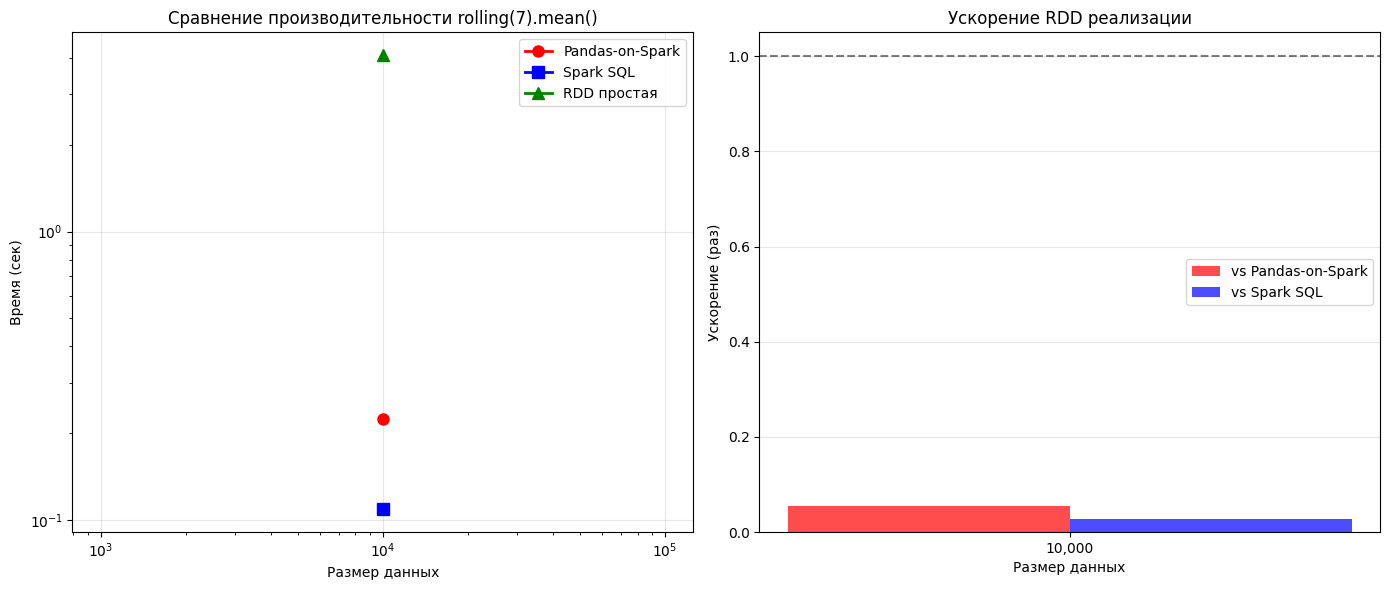


✅ Бенчмарк завершен!


In [14]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import pyspark.pandas as ps
import time
import numpy as np
import matplotlib.pyplot as plt

class OptimizedRollingMean:
    """
    Простая реализация скользящего среднего для RDD
    """
    
    def __init__(self, rdd, window_size=7):
        self.rdd = rdd
        self.window_size = window_size
    
    def compute(self):
        """
        Вычисляет скользящее среднее
        """
        window = self.window_size
        
        # Сортируем данные по индексу
        sorted_rdd = self.rdd.sortBy(lambda x: x[0])
        #sorted_rdd = self.rdd
        
        def process_partition(iterator):
            """
            Обрабатывает одну партицию
            """
            data = list(iterator)
            if not data:
                return iter([])
            
            result = []
            n = len(data)
            
            for i in range(n):
                # Начало окна
                start = max(0, i - window + 1)
                
                # Сумма значений в окне
                window_sum = 0.0
                for j in range(start, i + 1):
                    window_sum += data[j][1]
                
                # Количество элементов в окне
                window_count = i - start + 1
                
                # Среднее
                rolling_mean = window_sum / window_count
                
                result.append((data[i][0], data[i][1], rolling_mean))
            
            return iter(result)
        
        return sorted_rdd.mapPartitions(process_partition)


class RollingMeanBenchmark:
    """Исправленный бенчмарк"""
    
    def __init__(self):
        self.spark = SparkSession.builder \
            .appName("RollingMeanFairBenchmark") \
            .config("spark.sql.shuffle.partitions", "200") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
            .getOrCreate()
        
        self.sc = self.spark.sparkContext
    
    def generate_sorted_data(self, size, num_partitions=200):
        """Генерируем отсортированные данные"""
        data = [(i, float(np.random.randn())) for i in range(size)]
        rdd = self.sc.parallelize(data, num_partitions)
        df = self.spark.createDataFrame(data, ["index", "value"])
        
        # Правильное создание pandas-on-spark DataFrame
        ps_df = df.to_pandas_on_spark()
        
        return rdd, df, ps_df
    
    def benchmark_rdd_simple(self, rdd, window_size=7):
        """Простая RDD реализация"""

        start = time.time()
        
        optimizer = OptimizedRollingMean(rdd, window_size)
        result_rdd = optimizer.compute()
        
        # Материализуем результат
        count = result_rdd.count()
        rdd_time = time.time() - start
        print(result_rdd.toDebugString())
        
        print(f"    RDD простая: обработано {count} элементов за {rdd_time:.3f} сек")
        return rdd_time
    
    def benchmark_pandas_spark(self, ps_df, window_size=7):
        """Pandas-on-Spark benchmark"""
        start = time.time()
        
        # Вычисляем скользящее среднее
        result_series = ps_df['value'].rolling(window_size).mean()
        
        # Материализуем результат (разные версии pandas-on-spark)
        # Вариант 1: через to_numpy()
        result_array = result_series.to_numpy()
        
        # Вариант 2: если нужно вернуть в Spark, конвертируем обратно
        # result_df = result_series.to_frame().to_spark()
        # result_df.count()
        
        ps_time = time.time() - start
        print(f"    Pandas-on-Spark: обработано {len(result_array)} элементов за {ps_time:.3f} сек")
        return ps_time
    
    def benchmark_spark_sql(self, df, window_size=7):
        """Spark SQL benchmark"""
        
        window_spec = Window.orderBy("index").rowsBetween(-(window_size-1), 0)
        
        start = time.time()
        
        result_df = df.withColumn(
            "rolling_mean", 
            F.avg("value").over(window_spec)
        )
        
        # Материализуем результат
        count = result_df.count()
        spark_time = time.time() - start
        
        result_df.explain(True)
        result_df.explain(mode="extended")
        
        print(f"    Spark SQL: обработано {count} элементов за {spark_time:.3f} сек")
        return spark_time
    
    def verify_results(self, size=100):
        """Проверяет, что все реализации дают одинаковые результаты"""
        print("\n" + "="*60)
        print("ПРОВЕРКА КОРРЕКТНОСТИ")
        print("="*60)
        
        # Создаем простые данные для проверки
        test_data = [(i, float(i)) for i in range(size)]
        rdd = self.sc.parallelize(test_data, 3)
        df = self.spark.createDataFrame(test_data, ["index", "value"])
        ps_df = df.to_pandas_on_spark()
        
        window = 5
        
        # RDD реализация
        rdd_result = OptimizedRollingMean(rdd, window).compute().collect()
        
        # Spark SQL реализация
        window_spec = Window.orderBy("index").rowsBetween(-(window-1), 0)
        spark_result = df.withColumn("rolling_mean", F.avg("value").over(window_spec)) \
                         .orderBy("index") \
                         .collect()
        
        # Сравниваем первые несколько результатов
        print(f"\nСравнение для window={window} (первые 10 элементов):")
        print("index | RDD_mean | Spark_mean | Совпадают?")
        print("-" * 45)
        
        all_match = True
        for i in range(min(10, size)):
            rdd_val = rdd_result[i][2]
            spark_val = spark_result[i][2]
            match = abs(rdd_val - spark_val) < 0.0001
            all_match = all_match and match
            print(f"{i:5d} | {rdd_val:8.2f} | {spark_val:9.2f} | {match}")
        
        if all_match:
            print("\n✅ Все результаты совпадают!")
        else:
            print("\n❌ Обнаружены расхождения!")
        
        return all_match
    
    def run_benchmark(self, sizes=None):
        """Запускаем бенчмарк"""
        
        if sizes is None:
            sizes = [10000, 50000, 100000]
        
        window_size = 7
        results = []
        
        # Сначала проверяем корректность
        if not self.verify_results():
            print("Ошибка в реализации! Бенчмарк остановлен.")
            return results
        
        print("\n" + "="*60)
        print("ЗАПУСК БЕНЧМАРКА")
        print("="*60)
        
        for size in sizes:
            print(f"\n{'-'*50}")
            print(f"ТЕСТИРОВАНИЕ НА {size:,} ЭЛЕМЕНТОВ")
            print(f"{'-'*50}")
            
            # Генерируем данные
            rdd, df, ps_df = self.generate_sorted_data(size)
            
            # Прогрев (один раз)
            print("Прогрев...")
            self.benchmark_rdd_simple(rdd, window_size)
            self.benchmark_pandas_spark(ps_df, window_size)
            self.benchmark_spark_sql(df, window_size)
            
            # Реальные замеры (по 3 раза и берем среднее)
            print("\nРезультаты (среднее из 3 запусков):")
            
            ps_times = []
            spark_times = []
            rdd_times = []
            
            for run in range(3):
                print(f"  Запуск {run + 1}/3...")
                ps_times.append(self.benchmark_pandas_spark(ps_df, window_size))
                spark_times.append(self.benchmark_spark_sql(df, window_size))
                rdd_times.append(self.benchmark_rdd_simple(rdd, window_size))
            
            ps_avg = np.mean(ps_times)
            spark_avg = np.mean(spark_times)
            rdd_avg = np.mean(rdd_times)
            
            print(f"\n  📊 Pandas-on-Spark: {ps_avg:.3f} сек (среднее)")
            print(f"  🔥 Spark SQL: {spark_avg:.3f} сек (среднее)")
            print(f"  ⚡ RDD простая: {rdd_avg:.3f} сек (среднее)")
            print(f"  📈 Ускорение RDD vs Pandas: {ps_avg/rdd_avg:.2f}x")
            print(f"  📈 Ускорение RDD vs Spark SQL: {spark_avg/rdd_avg:.2f}x")
            
            results.append({
                'size': size,
                'pandas_spark': ps_avg,
                'spark_sql': spark_avg,
                'rdd_simple': rdd_avg
            })
        
        return results


def plot_results(results):
    """Визуализация результатов"""
    if not results:
        print("Нет данных для визуализации")
        return
    
    sizes = [r['size'] for r in results]
    ps_times = [r['pandas_spark'] for r in results]
    spark_times = [r['spark_sql'] for r in results]
    rdd_times = [r['rdd_simple'] for r in results]
    
    plt.figure(figsize=(14, 6))
    
    # График 1: Сравнение времени
    plt.subplot(1, 2, 1)
    plt.plot(sizes, ps_times, 'o-', label='Pandas-on-Spark', linewidth=2, markersize=8, color='red')
    plt.plot(sizes, spark_times, 's-', label='Spark SQL', linewidth=2, markersize=8, color='blue')
    plt.plot(sizes, rdd_times, '^-', label='RDD простая', linewidth=2, markersize=8, color='green')
    plt.xlabel('Размер данных')
    plt.ylabel('Время (сек)')
    plt.title('Сравнение производительности rolling(7).mean()')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    
    # График 2: Ускорение
    plt.subplot(1, 2, 2)
    speedup_vs_pandas = [ps/rdd for ps, rdd in zip(ps_times, rdd_times)]
    speedup_vs_spark = [spark/rdd for spark, rdd in zip(spark_times, rdd_times)]
    
    x = range(len(sizes))
    width = 0.35
    plt.bar([i - width/2 for i in x], speedup_vs_pandas, width, label='vs Pandas-on-Spark', color='red', alpha=0.7)
    plt.bar([i + width/2 for i in x], speedup_vs_spark, width, label='vs Spark SQL', color='blue', alpha=0.7)
    plt.xlabel('Размер данных')
    plt.ylabel('Ускорение (раз)')
    plt.title('Ускорение RDD реализации')
    plt.xticks(x, [f'{s:,}' for s in sizes])
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    print("="*60)
    print("ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО")
    print("="*60)
    
    # Создаем бенчмарк
    benchmark = RollingMeanBenchmark()
    
    # Запускаем на маленьких данных для проверки
    print("\nПроверка на маленьких данных...")
    benchmark.verify_results(50)
    
    # Запускаем бенчмарк
    print("\n" + "="*60)
    print("ЗАПУСК БЕНЧМАРКА")
    print("="*60)
    
    results = benchmark.run_benchmark(sizes=[10000]) # 10000, 50000, 100000, 500000, 
    
    # Визуализация
    if results:
        plot_results(results)
    
    print("\n✅ Бенчмарк завершен!")

In [35]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import pyspark.pandas as ps
import time
import numpy as np
import matplotlib.pyplot as plt

class OptimizedRollingMean:
    """
    Простая реализация скользящего среднего для RDD
    """
    
    def __init__(self, rdd, window_size=7):
        self.rdd = rdd
        self.window_size = window_size
    
    def compute(self):
        """
        Вычисляет скользящее среднее
        """
        window = self.window_size
        
        # Сортируем данные по индексу
        sorted_rdd = self.rdd.map(lambda x: (x[0] // window, x[1])).mapValues(lambda x: (x, 1)).reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])).mapValues(lambda x: x[0] / x[1])
        return sorted_rdd


class RollingMeanBenchmark:
    """Исправленный бенчмарк"""
    
    def __init__(self):
        self.spark = SparkSession.builder \
            .appName("RollingMeanFairBenchmark") \
            .config("spark.sql.shuffle.partitions", "200") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
            .getOrCreate()
        
        self.sc = self.spark.sparkContext
    
    def generate_sorted_data(self, size, num_partitions=200):
        """Генерируем отсортированные данные"""
        data = [(i, float(np.random.randn())) for i in range(size)]
        rdd = self.sc.parallelize(data, num_partitions)
        df = self.spark.createDataFrame(data, ["index", "value"])
        
        # Правильное создание pandas-on-spark DataFrame
        ps_df = df.to_pandas_on_spark()
        
        return rdd, df, ps_df
    
    def benchmark_rdd_simple(self, rdd, window_size=7):
        """Простая RDD реализация"""
        
        start = time.time()
        
        optimizer = OptimizedRollingMean(rdd, window_size)
        result_rdd = optimizer.compute()
        
        # Материализуем результат
        count = result_rdd.count()
        rdd_time = time.time() - start
        
        print(f"    RDD простая: обработано {count} элементов за {rdd_time:.3f} сек")
        return rdd_time
    
    def benchmark_pandas_spark(self, ps_df, window_size=7):
        """Pandas-on-Spark benchmark"""
        start = time.time()
        
        # Вычисляем скользящее среднее
        result_series = ps_df['value'].rolling(window_size).mean()
        
        # Материализуем результат (разные версии pandas-on-spark)
        # Вариант 1: через to_numpy()
        result_array = result_series.to_numpy()
        
        # Вариант 2: если нужно вернуть в Spark, конвертируем обратно
        # result_df = result_series.to_frame().to_spark()
        # result_df.count()
        
        ps_time = time.time() - start
        print(f"    Pandas-on-Spark: обработано {len(result_array)} элементов за {ps_time:.3f} сек")
        return ps_time

    def benchmark_dataframe(self, df, window_size=7):
        """Spark SQL benchmark"""
        
        window_spec = Window.orderBy("index").rowsBetween(-(window_size-1), 0)
        
        start = time.time()
        
        result = df.withColumn("window", F.floor(F.col("index") / window_size)) \
           .groupBy("window") \
           .agg(F.avg("value").alias("mean_value"))
        
        # Материализуем результат
        count = result.collect()
        spark_time = time.time() - start
        
        print(f"    Spark SQL: обработано элементов за {spark_time:.3f} сек")
        return spark_time
    
    def benchmark_spark_sql(self, df, window_size=7):
        """Spark SQL benchmark"""
        
        window_spec = Window.orderBy("index").rowsBetween(-(window_size-1), 0)
        
        start = time.time()
        
        result_df = df.withColumn(
            "rolling_mean", 
            F.avg("value").over(window_spec)
        )
        
        # Материализуем результат
        count = result_df.count()
        spark_time = time.time() - start
        
        print(f"    Spark SQL: обработано элементов за {spark_time:.3f} сек")
        return spark_time
    
    def verify_results(self, size=100):
        """Проверяет, что все реализации дают одинаковые результаты"""
        print("\n" + "="*60)
        print("ПРОВЕРКА КОРРЕКТНОСТИ")
        print("="*60)
        
        # Создаем простые данные для проверки
        test_data = [(i, float(i)) for i in range(size)]
        rdd = self.sc.parallelize(test_data, 3)
        df = self.spark.createDataFrame(test_data, ["index", "value"])
        ps_df = df.to_pandas_on_spark()
        
        window = 5
        
        # RDD реализация
        rdd_result = OptimizedRollingMean(rdd, window).compute().collect()
        
        # Spark SQL реализация
        window_spec = Window.orderBy("index").rowsBetween(-(window-1), 0)
        spark_result = df.withColumn("rolling_mean", F.avg("value").over(window_spec)) \
                         .orderBy("index") \
                         .collect()
        
        # Сравниваем первые несколько результатов
        print(f"\nСравнение для window={window} (первые 10 элементов):")
        print("index | RDD_mean | Spark_mean | Совпадают?")
        print("-" * 45)
        
        all_match = True
        for i in range(min(10, size)):
            rdd_val = rdd_result[i][1]
            spark_val = spark_result[i][2]
            match = abs(rdd_val - spark_val) < 0.0001
            all_match = all_match and match
            print(f"{i:5d} | {rdd_val:8.2f} | {spark_val:9.2f} | {match}")
        
        if all_match:
            print("\n✅ Все результаты совпадают!")
        else:
            print("\n❌ Обнаружены расхождения!")
        
        return all_match
    
    def run_benchmark(self, sizes=None):
        """Запускаем бенчмарк"""
        
        if sizes is None:
            sizes = [10000, 50000, 100000]
        
        window_size = 7
        results = []
        
        # Сначала проверяем корректность
        #if not self.verify_results():
        #    print("Ошибка в реализации! Бенчмарк остановлен.")
        #    return results
        
        print("\n" + "="*60)
        print("ЗАПУСК БЕНЧМАРКА")
        print("="*60)
        
        for size in sizes:
            print(f"\n{'-'*50}")
            print(f"ТЕСТИРОВАНИЕ НА {size:,} ЭЛЕМЕНТОВ")
            print(f"{'-'*50}")
            
            # Генерируем данные
            rdd, df, ps_df = self.generate_sorted_data(size)
            
            # Прогрев (один раз)
            print("Прогрев...")
            self.benchmark_rdd_simple(rdd, window_size)
            #self.benchmark_pandas_spark(ps_df, window_size)
            #self.benchmark_spark_sql(df, window_size)
            
            # Реальные замеры (по 3 раза и берем среднее)
            print("\nРезультаты (среднее из 3 запусков):")
            
            ps_times = []
            spark_times = []
            rdd_times = []
            
            for run in range(3):
                print(f"  Запуск {run + 1}/3...")
                #ps_times.append(self.benchmark_pandas_spark(ps_df, window_size))
                #spark_times.append(self.benchmark_spark_sql(df, window_size))
                rdd_times.append(self.benchmark_rdd_simple(rdd, window_size))
                spark_times.append(self.benchmark_dataframe(df, window_size))
            
            #ps_avg = np.mean(ps_times)
            #spark_avg = np.mean(spark_times)
            rdd_avg = np.mean(rdd_times)
            
            #print(f"\n  📊 Pandas-on-Spark: {ps_avg:.3f} сек (среднее)")
            print(f"  🔥 Spark SQL: {spark_avg:.3f} сек (среднее)")
            print(f"  ⚡ RDD простая: {rdd_avg:.3f} сек (среднее)")
            #print(f"  📈 Ускорение RDD vs Pandas: {ps_avg/rdd_avg:.2f}x")
            #print(f"  📈 Ускорение RDD vs Spark SQL: {spark_avg/rdd_avg:.2f}x")

            ps_avg = 999
            results.append({
                'size': size,
                'pandas_spark': ps_avg,
                'spark_sql': spark_avg,
                'rdd_simple': rdd_avg
            })
        
        return results


def plot_results(results):
    """Визуализация результатов"""
    if not results:
        print("Нет данных для визуализации")
        return
    
    sizes = [r['size'] for r in results]
    ps_times = [r['pandas_spark'] for r in results]
    spark_times = [r['spark_sql'] for r in results]
    rdd_times = [r['rdd_simple'] for r in results]
    
    plt.figure(figsize=(14, 6))
    
    # График 1: Сравнение времени
    plt.subplot(1, 2, 1)
    plt.plot(sizes, ps_times, 'o-', label='Pandas-on-Spark', linewidth=2, markersize=8, color='red')
    plt.plot(sizes, spark_times, 's-', label='Spark SQL', linewidth=2, markersize=8, color='blue')
    plt.plot(sizes, rdd_times, '^-', label='RDD простая', linewidth=2, markersize=8, color='green')
    plt.xlabel('Размер данных')
    plt.ylabel('Время (сек)')
    plt.title('Сравнение производительности rolling(7).mean()')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    
    # График 2: Ускорение
    plt.subplot(1, 2, 2)
    speedup_vs_pandas = [ps/rdd for ps, rdd in zip(ps_times, rdd_times)]
    speedup_vs_spark = [spark/rdd for spark, rdd in zip(spark_times, rdd_times)]
    
    x = range(len(sizes))
    width = 0.35
    plt.bar([i - width/2 for i in x], speedup_vs_pandas, width, label='vs Pandas-on-Spark', color='red', alpha=0.7)
    plt.bar([i + width/2 for i in x], speedup_vs_spark, width, label='vs Spark SQL', color='blue', alpha=0.7)
    plt.xlabel('Размер данных')
    plt.ylabel('Ускорение (раз)')
    plt.title('Ускорение RDD реализации')
    plt.xticks(x, [f'{s:,}' for s in sizes])
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    print("="*60)
    print("ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО")
    print("="*60)
    
    # Создаем бенчмарк
    benchmark = RollingMeanBenchmark()
    
    # Запускаем на маленьких данных для проверки
    print("\nПроверка на маленьких данных...")
   # benchmark.verify_results(50)
    
    # Запускаем бенчмарк
    print("\n" + "="*60)
    print("ЗАПУСК БЕНЧМАРКА")
    print("="*60)
    
    results = benchmark.run_benchmark(sizes=[10000, 50000]) # 10000, 50000, 100000, 500000, 

    print("\n✅ Бенчмарк завершен!")

ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО

Проверка на маленьких данных...

ЗАПУСК БЕНЧМАРКА

ЗАПУСК БЕНЧМАРКА

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 10,000 ЭЛЕМЕНТОВ
--------------------------------------------------
Прогрев...


    RDD простая: обработано 1429 элементов за 2.290 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


    RDD простая: обработано 1429 элементов за 2.528 сек
    Spark SQL: обработано элементов за 0.190 сек
  Запуск 2/3...


    RDD простая: обработано 1429 элементов за 2.618 сек
    Spark SQL: обработано элементов за 0.156 сек
  Запуск 3/3...


    RDD простая: обработано 1429 элементов за 2.297 сек
    Spark SQL: обработано элементов за 0.168 сек


NameError: name 'spark_avg' is not defined

/usr/local/lib/python3.8/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО


26/02/17 21:43:01 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.



Проверка на маленьких данных...

ПРОВЕРКА КОРРЕКТНОСТИ


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
26/02/17 21:43:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



Сравнение для window=5 (первые 10 элементов):
index | RDD_mean | Spark_mean | Совпадают?
---------------------------------------------
    0 |     0.00 |      0.00 | True
    1 |     0.50 |      0.50 | True
    2 |     1.00 |      1.00 | True
    3 |     1.50 |      1.50 | True
    4 |     2.00 |      2.00 | True
    5 |     3.00 |      3.00 | True
    6 |     4.00 |      4.00 | True
    7 |     5.00 |      5.00 | True
    8 |     6.00 |      6.00 | True
    9 |     7.00 |      7.00 | True

✅ Все результаты совпадают!

ЗАПУСК БЕНЧМАРКА

ПРОВЕРКА КОРРЕКТНОСТИ


26/02/17 21:43:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



Сравнение для window=5 (первые 10 элементов):
index | RDD_mean | Spark_mean | Совпадают?
---------------------------------------------
    0 |     0.00 |      0.00 | True
    1 |     0.50 |      0.50 | True
    2 |     1.00 |      1.00 | True
    3 |     1.50 |      1.50 | True
    4 |     2.00 |      2.00 | True
    5 |     3.00 |      3.00 | True
    6 |     4.00 |      4.00 | True
    7 |     5.00 |      5.00 | True
    8 |     6.00 |      6.00 | True
    9 |     7.00 |      7.00 | True

✅ Все результаты совпадают!

ЗАПУСК БЕНЧМАРКА

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 10,000 ЭЛЕМЕНТОВ
--------------------------------------------------
Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:43:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 10000 элементов за 5.854 сек


26/02/17 21:43:11 WARN AttachDistributedSequenceExec: clean up cached RDD(52) in AttachDistributedSequenceExec(121)
26/02/17 21:43:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 10000 элементов за 0.632 сек
    Spark SQL: обработано 10000 элементов за 0.214 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:43:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:12 WARN AttachDistributedSequenceExec: clean up cached RDD(68) in AttachDistributedSequenceExec(233)
26/02/17 21:43:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a sin

    Pandas-on-Spark: обработано 10000 элементов за 0.356 сек
    Spark SQL: обработано 10000 элементов за 0.165 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


    RDD простая: обработано 10000 элементов за 3.979 сек
  Запуск 2/3...


26/02/17 21:43:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:16 WARN AttachDistributedSequenceExec: clean up cached RDD(91) in AttachDistributedSequenceExec(345)
26/02/17 21:43:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 10000 элементов за 0.312 сек
    Spark SQL: обработано 10000 элементов за 0.137 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:43:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 10000 элементов за 5.190 сек
  Запуск 3/3...


26/02/17 21:43:22 WARN AttachDistributedSequenceExec: clean up cached RDD(114) in AttachDistributedSequenceExec(457)
26/02/17 21:43:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 10000 элементов за 0.296 сек
    Spark SQL: обработано 10000 элементов за 0.134 сек


    RDD простая: обработано 10000 элементов за 3.920 сек

  📊 Pandas-on-Spark: 0.321 сек (среднее)
  🔥 Spark SQL: 0.145 сек (среднее)
  ⚡ RDD простая: 4.363 сек (среднее)
  📈 Ускорение RDD vs Pandas: 0.07x
  📈 Ускорение RDD vs Spark SQL: 0.03x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 50,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:43:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 50000 элементов за 5.377 сек


26/02/17 21:43:32 WARN AttachDistributedSequenceExec: clean up cached RDD(150) in AttachDistributedSequenceExec(569)
26/02/17 21:43:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 50000 элементов за 0.323 сек
    Spark SQL: обработано 50000 элементов за 0.101 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:43:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:33 WARN AttachDistributedSequenceExec: clean up cached RDD(166) in AttachDistributedSequenceExec(681)
26/02/17 21:43:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a si

    Pandas-on-Spark: обработано 50000 элементов за 0.343 сек
    Spark SQL: обработано 50000 элементов за 0.109 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:43:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 50000 элементов за 3.995 сек
  Запуск 2/3...


26/02/17 21:43:37 WARN AttachDistributedSequenceExec: clean up cached RDD(189) in AttachDistributedSequenceExec(793)
26/02/17 21:43:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 50000 элементов за 0.313 сек
    Spark SQL: обработано 50000 элементов за 0.113 сек


    RDD простая: обработано 50000 элементов за 4.721 сек
  Запуск 3/3...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:43:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:42 WARN AttachDistributedSequenceExec: clean up cached RDD(212) in AttachDistributedSequenceExec(905)
26/02/17 21:43:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a si

    Pandas-on-Spark: обработано 50000 элементов за 0.364 сек
    Spark SQL: обработано 50000 элементов за 0.116 сек


    RDD простая: обработано 50000 элементов за 4.033 сек

  📊 Pandas-on-Spark: 0.340 сек (среднее)
  🔥 Spark SQL: 0.113 сек (среднее)
  ⚡ RDD простая: 4.250 сек (среднее)
  📈 Ускорение RDD vs Pandas: 0.08x
  📈 Ускорение RDD vs Spark SQL: 0.03x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 100,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:43:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 100000 элементов за 4.733 сек


26/02/17 21:43:52 WARN AttachDistributedSequenceExec: clean up cached RDD(248) in AttachDistributedSequenceExec(1017)
26/02/17 21:43:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 100000 элементов за 0.506 сек
    Spark SQL: обработано 100000 элементов за 0.105 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:43:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:53 WARN AttachDistributedSequenceExec: clean up cached RDD(264) in AttachDistributedSequenceExec(1129)
26/02/17 21:43:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a s

    Pandas-on-Spark: обработано 100000 элементов за 0.488 сек
    Spark SQL: обработано 100000 элементов за 0.089 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:43:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 100000 элементов за 3.855 сек
  Запуск 2/3...


26/02/17 21:43:57 WARN AttachDistributedSequenceExec: clean up cached RDD(287) in AttachDistributedSequenceExec(1241)
26/02/17 21:43:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:43:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 100000 элементов за 0.401 сек
    Spark SQL: обработано 100000 элементов за 0.086 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:44:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:03 WARN AttachDistributedSequenceExec: clean up cached RDD(310) in AttachDistributedSequenceExec(1353)
26/02/17 21:44:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a s

    RDD простая: обработано 100000 элементов за 5.048 сек
  Запуск 3/3...
    Pandas-on-Spark: обработано 100000 элементов за 0.488 сек
    Spark SQL: обработано 100000 элементов за 0.079 сек


    RDD простая: обработано 100000 элементов за 3.854 сек

  📊 Pandas-on-Spark: 0.459 сек (среднее)
  🔥 Spark SQL: 0.085 сек (среднее)
  ⚡ RDD простая: 4.253 сек (среднее)
  📈 Ускорение RDD vs Pandas: 0.11x
  📈 Ускорение RDD vs Spark SQL: 0.02x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 500,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:44:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 500000 элементов за 3.986 сек


26/02/17 21:44:17 WARN AttachDistributedSequenceExec: clean up cached RDD(346) in AttachDistributedSequenceExec(1465)
26/02/17 21:44:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 500000 элементов за 1.597 сек
    Spark SQL: обработано 500000 элементов за 0.180 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:44:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:18 WARN AttachDistributedSequenceExec: clean up cached RDD(362) in AttachDistributedSequenceExec(1577)
26/02/17 21:44:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a s

    Pandas-on-Spark: обработано 500000 элементов за 1.712 сек
    Spark SQL: обработано 500000 элементов за 0.492 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:44:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 500000 элементов за 4.097 сек
  Запуск 2/3...


26/02/17 21:44:25 WARN AttachDistributedSequenceExec: clean up cached RDD(385) in AttachDistributedSequenceExec(1689)
26/02/17 21:44:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 500000 элементов за 1.472 сек
    Spark SQL: обработано 500000 элементов за 0.142 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:44:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 500000 элементов за 4.483 сек
  Запуск 3/3...


26/02/17 21:44:31 WARN AttachDistributedSequenceExec: clean up cached RDD(408) in AttachDistributedSequenceExec(1801)
26/02/17 21:44:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:44:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 500000 элементов за 1.466 сек
    Spark SQL: обработано 500000 элементов за 0.154 сек


    RDD простая: обработано 500000 элементов за 4.076 сек

  📊 Pandas-on-Spark: 1.550 сек (среднее)
  🔥 Spark SQL: 0.263 сек (среднее)
  ⚡ RDD простая: 4.219 сек (среднее)
  📈 Ускорение RDD vs Pandas: 0.37x
  📈 Ускорение RDD vs Spark SQL: 0.06x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 10,000,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:46:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:46:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:46:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:46:07 WARN TaskSetManager: Stage 194 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.


    RDD простая: обработано 10000000 элементов за 6.715 сек


26/02/17 21:46:09 WARN TaskSetManager: Stage 195 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:46:11 WARN AttachDistributedSequenceExec: clean up cached RDD(444) in AttachDistributedSequenceExec(1913)
26/02/17 21:46:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:46:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 10000000 элементов за 28.154 сек


26/02/17 21:46:36 WARN TaskSetManager: Stage 198 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    Spark SQL: обработано 10000000 элементов за 0.906 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:46:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:46:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:46:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:46:37 WARN TaskSetManager: Stage 201 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:46:38 WARN TaskSetManager: Stage 202 contains a task of very l

    Pandas-on-Spark: обработано 10000000 элементов за 24.619 сек


26/02/17 21:47:01 WARN TaskSetManager: Stage 205 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    Spark SQL: обработано 10000000 элементов за 0.969 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:47:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:47:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:47:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:47:09 WARN TaskSetManager: Stage 212 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.


    RDD простая: обработано 10000000 элементов за 6.557 сек
  Запуск 2/3...


26/02/17 21:47:11 WARN TaskSetManager: Stage 213 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:47:12 WARN AttachDistributedSequenceExec: clean up cached RDD(483) in AttachDistributedSequenceExec(2137)
26/02/17 21:47:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:47:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 10000000 элементов за 26.026 сек


26/02/17 21:47:35 WARN TaskSetManager: Stage 216 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    Spark SQL: обработано 10000000 элементов за 0.894 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:47:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:47:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:47:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:47:43 WARN TaskSetManager: Stage 223 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.


    RDD простая: обработано 10000000 элементов за 7.638 сек
  Запуск 3/3...


26/02/17 21:47:45 WARN TaskSetManager: Stage 224 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:47:46 WARN AttachDistributedSequenceExec: clean up cached RDD(506) in AttachDistributedSequenceExec(2249)
26/02/17 21:47:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:47:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 10000000 элементов за 24.361 сек


26/02/17 21:48:08 WARN TaskSetManager: Stage 227 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    Spark SQL: обработано 10000000 элементов за 1.060 сек


    RDD простая: обработано 10000000 элементов за 7.254 сек

  📊 Pandas-on-Spark: 25.002 сек (среднее)
  🔥 Spark SQL: 0.974 сек (среднее)
  ⚡ RDD простая: 7.150 сек (среднее)
  📈 Ускорение RDD vs Pandas: 3.50x
  📈 Ускорение RDD vs Spark SQL: 0.14x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 20,000,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


26/02/17 21:51:03 WARN TaskSetManager: Stage 234 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:51:04 WARN TaskSetManager: Stage 235 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:51:06 WARN TaskSetManager: Stage 236 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:51:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:51:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, th

    RDD простая: обработано 20000000 элементов за 12.294 сек


26/02/17 21:51:18 WARN TaskSetManager: Stage 239 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:51:22 WARN AttachDistributedSequenceExec: clean up cached RDD(542) in AttachDistributedSequenceExec(2361)
26/02/17 21:51:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:51:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 20000000 элементов за 55.943 сек


26/02/17 21:52:12 WARN TaskSetManager: Stage 242 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:52:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:52:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:52:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:52:13 WARN TaskSetManager: Stage 245 contains a task of very l

    Spark SQL: обработано 20000000 элементов за 1.758 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


26/02/17 21:52:16 WARN TaskSetManager: Stage 246 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:52:18 WARN AttachDistributedSequenceExec: clean up cached RDD(558) in AttachDistributedSequenceExec(2473)
26/02/17 21:52:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:52:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 20000000 элементов за 48.150 сек


26/02/17 21:53:01 WARN TaskSetManager: Stage 249 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:53:03 WARN TaskSetManager: Stage 252 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


    Spark SQL: обработано 20000000 элементов за 2.041 сек


26/02/17 21:53:05 WARN TaskSetManager: Stage 253 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:53:06 WARN TaskSetManager: Stage 254 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:53:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:53:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:53:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to 

    RDD простая: обработано 20000000 элементов за 11.472 сек
  Запуск 2/3...


26/02/17 21:53:18 WARN TaskSetManager: Stage 257 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:53:20 WARN AttachDistributedSequenceExec: clean up cached RDD(581) in AttachDistributedSequenceExec(2585)
26/02/17 21:53:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:53:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 20000000 элементов за 49.300 сек


26/02/17 21:54:04 WARN TaskSetManager: Stage 260 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:54:06 WARN TaskSetManager: Stage 263 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


    Spark SQL: обработано 20000000 элементов за 1.881 сек


26/02/17 21:54:07 WARN TaskSetManager: Stage 264 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:54:10 WARN TaskSetManager: Stage 265 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 21:54:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:54:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:54:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to 

    RDD простая: обработано 20000000 элементов за 14.256 сек
  Запуск 3/3...


26/02/17 21:54:23 WARN TaskSetManager: Stage 268 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:54:25 WARN AttachDistributedSequenceExec: clean up cached RDD(604) in AttachDistributedSequenceExec(2697)
26/02/17 21:54:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 21:54:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 20000000 элементов за 48.045 сек


26/02/17 21:55:08 WARN TaskSetManager: Stage 271 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:55:11 WARN TaskSetManager: Stage 274 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


    Spark SQL: обработано 20000000 элементов за 2.823 сек


26/02/17 21:55:13 WARN TaskSetManager: Stage 275 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 21:55:14 WARN TaskSetManager: Stage 276 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    RDD простая: обработано 20000000 элементов за 12.372 сек

  📊 Pandas-on-Spark: 48.499 сек (среднее)
  🔥 Spark SQL: 2.248 сек (среднее)
  ⚡ RDD простая: 12.700 сек (среднее)
  📈 Ускорение RDD vs Pandas: 3.82x
  📈 Ускорение RDD vs Spark SQL: 0.18x


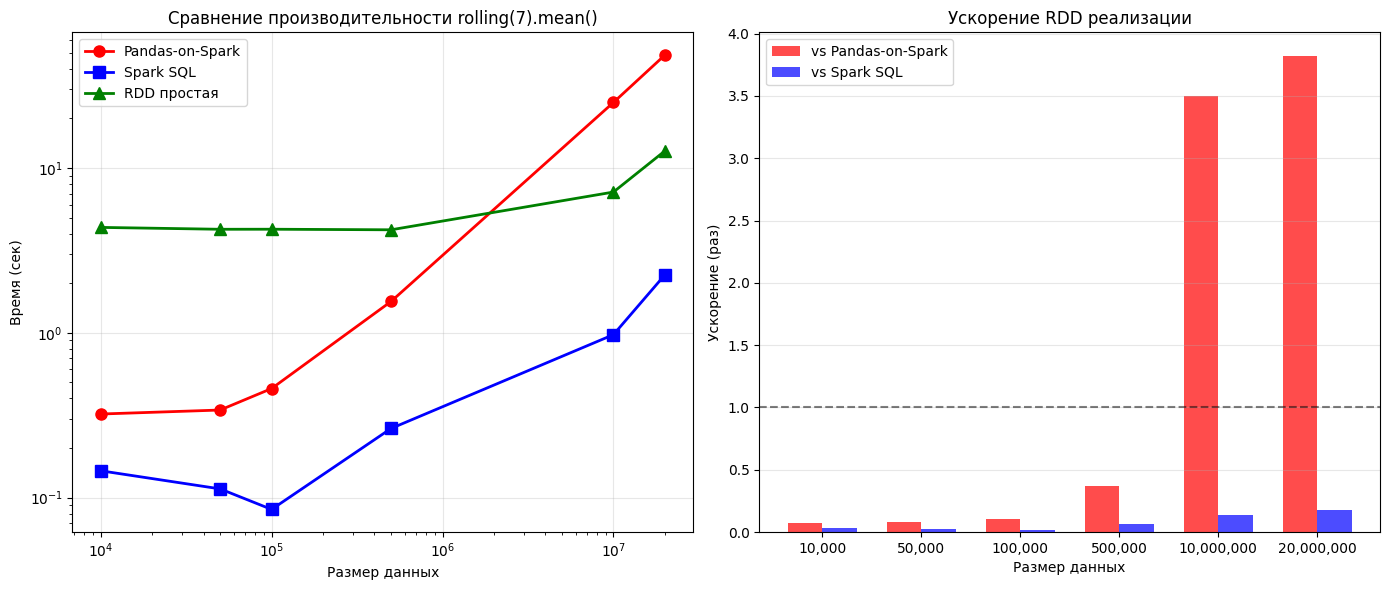


✅ Бенчмарк завершен!


In [10]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import pyspark.pandas as ps
import time
import numpy as np
import matplotlib.pyplot as plt

class OptimizedRollingMean:
    """
    Простая реализация скользящего среднего для RDD
    """
    
    def __init__(self, rdd, window_size=7):
        self.rdd = rdd
        self.window_size = window_size
    
    def compute(self):
        """
        Вычисляет скользящее среднее
        """
        window = self.window_size
        
        # Сортируем данные по индексу
        sorted_rdd = self.rdd.sortBy(lambda x: x[0])
        #sorted_rdd = self.rdd
        
        def process_partition(iterator):
            """
            Обрабатывает одну партицию
            """
            data = list(iterator)
            if not data:
                return iter([])
            
            result = []
            n = len(data)
            
            for i in range(n):
                # Начало окна
                start = max(0, i - window + 1)
                
                # Сумма значений в окне
                window_sum = 0.0
                for j in range(start, i + 1):
                    window_sum += data[j][1]
                
                # Количество элементов в окне
                window_count = i - start + 1
                
                # Среднее
                rolling_mean = window_sum / window_count
                
                result.append((data[i][0], data[i][1], rolling_mean))
            
            return iter(result)
        
        return sorted_rdd.mapPartitions(process_partition)


class RollingMeanBenchmark:
    """Исправленный бенчмарк"""
    
    def __init__(self):
        self.spark = SparkSession.builder \
            .appName("RollingMeanFairBenchmark") \
            .config("spark.sql.shuffle.partitions", "200") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
            .getOrCreate()
        
        self.sc = self.spark.sparkContext
    
    def generate_sorted_data(self, size, num_partitions=200):
        """Генерируем отсортированные данные"""
        data = [(i, float(np.random.randn())) for i in range(size)]
        rdd = self.sc.parallelize(data, num_partitions)
        df = self.spark.createDataFrame(data, ["index", "value"])
        
        # Правильное создание pandas-on-spark DataFrame
        ps_df = df.to_pandas_on_spark()
        
        return rdd, df, ps_df
    
    def benchmark_rdd_simple(self, rdd, window_size=7):
        """Простая RDD реализация"""
        
        start = time.time()
        
        optimizer = OptimizedRollingMean(rdd, window_size)
        result_rdd = optimizer.compute()
        
        # Материализуем результат
        count = result_rdd.count()
        rdd_time = time.time() - start
        
        print(f"    RDD простая: обработано {count} элементов за {rdd_time:.3f} сек")
        return rdd_time
    
    def benchmark_pandas_spark(self, ps_df, window_size=7):
        """Pandas-on-Spark benchmark"""
        start = time.time()
        
        # Вычисляем скользящее среднее
        result_series = ps_df['value'].rolling(window_size).mean()
        
        # Материализуем результат (разные версии pandas-on-spark)
        # Вариант 1: через to_numpy()
        result_array = result_series.to_numpy()
        
        # Вариант 2: если нужно вернуть в Spark, конвертируем обратно
        # result_df = result_series.to_frame().to_spark()
        # result_df.count()
        
        ps_time = time.time() - start
        print(f"    Pandas-on-Spark: обработано {len(result_array)} элементов за {ps_time:.3f} сек")
        return ps_time
    
    def benchmark_spark_sql(self, df, window_size=7):
        """Spark SQL benchmark"""
        
        window_spec = Window.orderBy("index").rowsBetween(-(window_size-1), 0)
        
        start = time.time()
        
        result_df = df.withColumn(
            "rolling_mean", 
            F.avg("value").over(window_spec)
        )
        
        # Материализуем результат
        count = result_df.count()
        spark_time = time.time() - start
        
        print(f"    Spark SQL: обработано {count} элементов за {spark_time:.3f} сек")
        return spark_time
    
    def verify_results(self, size=100):
        """Проверяет, что все реализации дают одинаковые результаты"""
        print("\n" + "="*60)
        print("ПРОВЕРКА КОРРЕКТНОСТИ")
        print("="*60)
        
        # Создаем простые данные для проверки
        test_data = [(i, float(i)) for i in range(size)]
        rdd = self.sc.parallelize(test_data, 3)
        df = self.spark.createDataFrame(test_data, ["index", "value"])
        ps_df = df.to_pandas_on_spark()
        
        window = 5
        
        # RDD реализация
        rdd_result = OptimizedRollingMean(rdd, window).compute().collect()
        
        # Spark SQL реализация
        window_spec = Window.orderBy("index").rowsBetween(-(window-1), 0)
        spark_result = df.withColumn("rolling_mean", F.avg("value").over(window_spec)) \
                         .orderBy("index") \
                         .collect()
        
        # Сравниваем первые несколько результатов
        print(f"\nСравнение для window={window} (первые 10 элементов):")
        print("index | RDD_mean | Spark_mean | Совпадают?")
        print("-" * 45)
        
        all_match = True
        for i in range(min(10, size)):
            rdd_val = rdd_result[i][2]
            spark_val = spark_result[i][2]
            match = abs(rdd_val - spark_val) < 0.0001
            all_match = all_match and match
            print(f"{i:5d} | {rdd_val:8.2f} | {spark_val:9.2f} | {match}")
        
        if all_match:
            print("\n✅ Все результаты совпадают!")
        else:
            print("\n❌ Обнаружены расхождения!")
        
        return all_match
    
    def run_benchmark(self, sizes=None):
        """Запускаем бенчмарк"""
        
        if sizes is None:
            sizes = [10000, 50000, 100000]
        
        window_size = 7
        results = []
        
        # Сначала проверяем корректность
        if not self.verify_results():
            print("Ошибка в реализации! Бенчмарк остановлен.")
            return results
        
        print("\n" + "="*60)
        print("ЗАПУСК БЕНЧМАРКА")
        print("="*60)
        
        for size in sizes:
            print(f"\n{'-'*50}")
            print(f"ТЕСТИРОВАНИЕ НА {size:,} ЭЛЕМЕНТОВ")
            print(f"{'-'*50}")
            
            # Генерируем данные
            rdd, df, ps_df = self.generate_sorted_data(size)
            
            # Прогрев (один раз)
            print("Прогрев...")
            self.benchmark_rdd_simple(rdd, window_size)
            self.benchmark_pandas_spark(ps_df, window_size)
            self.benchmark_spark_sql(df, window_size)
            
            # Реальные замеры (по 3 раза и берем среднее)
            print("\nРезультаты (среднее из 3 запусков):")
            
            ps_times = []
            spark_times = []
            rdd_times = []
            
            for run in range(3):
                print(f"  Запуск {run + 1}/3...")
                ps_times.append(self.benchmark_pandas_spark(ps_df, window_size))
                spark_times.append(self.benchmark_spark_sql(df, window_size))
                rdd_times.append(self.benchmark_rdd_simple(rdd, window_size))
            
            ps_avg = np.mean(ps_times)
            spark_avg = np.mean(spark_times)
            rdd_avg = np.mean(rdd_times)
            
            print(f"\n  📊 Pandas-on-Spark: {ps_avg:.3f} сек (среднее)")
            print(f"  🔥 Spark SQL: {spark_avg:.3f} сек (среднее)")
            print(f"  ⚡ RDD простая: {rdd_avg:.3f} сек (среднее)")
            print(f"  📈 Ускорение RDD vs Pandas: {ps_avg/rdd_avg:.2f}x")
            print(f"  📈 Ускорение RDD vs Spark SQL: {spark_avg/rdd_avg:.2f}x")
            
            results.append({
                'size': size,
                'pandas_spark': ps_avg,
                'spark_sql': spark_avg,
                'rdd_simple': rdd_avg
            })
        
        return results


def plot_results(results):
    """Визуализация результатов"""
    if not results:
        print("Нет данных для визуализации")
        return
    
    sizes = [r['size'] for r in results]
    ps_times = [r['pandas_spark'] for r in results]
    spark_times = [r['spark_sql'] for r in results]
    rdd_times = [r['rdd_simple'] for r in results]
    
    plt.figure(figsize=(14, 6))
    
    # График 1: Сравнение времени
    plt.subplot(1, 2, 1)
    plt.plot(sizes, ps_times, 'o-', label='Pandas-on-Spark', linewidth=2, markersize=8, color='red')
    plt.plot(sizes, spark_times, 's-', label='Spark SQL', linewidth=2, markersize=8, color='blue')
    plt.plot(sizes, rdd_times, '^-', label='RDD простая', linewidth=2, markersize=8, color='green')
    plt.xlabel('Размер данных')
    plt.ylabel('Время (сек)')
    plt.title('Сравнение производительности rolling(7).mean()')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    
    # График 2: Ускорение
    plt.subplot(1, 2, 2)
    speedup_vs_pandas = [ps/rdd for ps, rdd in zip(ps_times, rdd_times)]
    speedup_vs_spark = [spark/rdd for spark, rdd in zip(spark_times, rdd_times)]
    
    x = range(len(sizes))
    width = 0.35
    plt.bar([i - width/2 for i in x], speedup_vs_pandas, width, label='vs Pandas-on-Spark', color='red', alpha=0.7)
    plt.bar([i + width/2 for i in x], speedup_vs_spark, width, label='vs Spark SQL', color='blue', alpha=0.7)
    plt.xlabel('Размер данных')
    plt.ylabel('Ускорение (раз)')
    plt.title('Ускорение RDD реализации')
    plt.xticks(x, [f'{s:,}' for s in sizes])
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    print("="*60)
    print("ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО")
    print("="*60)
    
    # Создаем бенчмарк
    benchmark = RollingMeanBenchmark()
    
    # Запускаем на маленьких данных для проверки
    print("\nПроверка на маленьких данных...")
    benchmark.verify_results(50)
    
    # Запускаем бенчмарк
    print("\n" + "="*60)
    print("ЗАПУСК БЕНЧМАРКА")
    print("="*60)
    
    results = benchmark.run_benchmark(sizes=[10000, 50000, 100000, 500000, 10000000, 20000000]) # 10000, 50000, 100000, 500000, 
    
    # Визуализация
    if results:
        plot_results(results)
    
    print("\n✅ Бенчмарк завершен!")

ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО

Проверка на маленьких данных...

ПРОВЕРКА КОРРЕКТНОСТИ


26/02/17 22:02:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



Сравнение для window=5 (первые 10 элементов):
index | RDD_mean | Spark_mean | Совпадают?
---------------------------------------------
    0 |     0.00 |      0.00 | True
    1 |     0.50 |      0.50 | True
    2 |     1.00 |      1.00 | True
    3 |     1.50 |      1.50 | True
    4 |     2.00 |      2.00 | True
    5 |     3.00 |      3.00 | True
    6 |     4.00 |      4.00 | True
    7 |     5.00 |      5.00 | True
    8 |     6.00 |      6.00 | True
    9 |     7.00 |      7.00 | True

✅ Все результаты совпадают!

ЗАПУСК БЕНЧМАРКА

ПРОВЕРКА КОРРЕКТНОСТИ


26/02/17 22:02:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



Сравнение для window=5 (первые 10 элементов):
index | RDD_mean | Spark_mean | Совпадают?
---------------------------------------------
    0 |     0.00 |      0.00 | True
    1 |     0.50 |      0.50 | True
    2 |     1.00 |      1.00 | True
    3 |     1.50 |      1.50 | True
    4 |     2.00 |      2.00 | True
    5 |     3.00 |      3.00 | True
    6 |     4.00 |      4.00 | True
    7 |     5.00 |      5.00 | True
    8 |     6.00 |      6.00 | True
    9 |     7.00 |      7.00 | True

✅ Все результаты совпадают!

ЗАПУСК БЕНЧМАРКА

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 10,000 ЭЛЕМЕНТОВ
--------------------------------------------------
Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:02:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 10000 элементов за 3.777 сек


26/02/17 22:02:40 WARN AttachDistributedSequenceExec: clean up cached RDD(690) in AttachDistributedSequenceExec(2887)
26/02/17 22:02:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


    Pandas-on-Spark: обработано 10000 элементов за 0.243 сек
    Spark SQL: обработано 10000 элементов за 0.111 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


26/02/17 22:02:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:40 WARN AttachDistributedSequenceExec: clean up cached RDD(706) in AttachDistributedSequenceExec(2999)
26/02/17 22:02:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 10000 элементов за 0.546 сек
    Spark SQL: обработано 10000 элементов за 0.116 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:02:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 10000 элементов за 3.671 сек
  Запуск 2/3...


26/02/17 22:02:44 WARN AttachDistributedSequenceExec: clean up cached RDD(729) in AttachDistributedSequenceExec(3111)
26/02/17 22:02:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 10000 элементов за 0.261 сек
    Spark SQL: обработано 10000 элементов за 0.116 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:02:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 10000 элементов за 3.878 сек
  Запуск 3/3...


26/02/17 22:02:49 WARN AttachDistributedSequenceExec: clean up cached RDD(752) in AttachDistributedSequenceExec(3223)
26/02/17 22:02:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 10000 элементов за 0.868 сек
    Spark SQL: обработано 10000 элементов за 0.100 сек


    RDD простая: обработано 10000 элементов за 4.182 сек

  📊 Pandas-on-Spark: 0.558 сек (среднее)
  🔥 Spark SQL: 0.111 сек (среднее)
  ⚡ RDD простая: 3.910 сек (среднее)
  📈 Ускорение RDD vs Pandas: 0.14x
  📈 Ускорение RDD vs Spark SQL: 0.03x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 50,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:02:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 50000 элементов за 3.931 сек


26/02/17 22:02:58 WARN AttachDistributedSequenceExec: clean up cached RDD(788) in AttachDistributedSequenceExec(3335)
26/02/17 22:02:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 50000 элементов за 0.275 сек
    Spark SQL: обработано 50000 элементов за 0.092 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:02:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:02:58 WARN AttachDistributedSequenceExec: clean up cached RDD(804) in AttachDistributedSequenceExec(3447)
26/02/17 22:02:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a s

    Pandas-on-Spark: обработано 50000 элементов за 0.284 сек
    Spark SQL: обработано 50000 элементов за 0.091 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:03:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:04 WARN AttachDistributedSequenceExec: clean up cached RDD(827) in AttachDistributedSequenceExec(3559)
26/02/17 22:03:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a s

    RDD простая: обработано 50000 элементов за 4.822 сек
  Запуск 2/3...
    Pandas-on-Spark: обработано 50000 элементов за 0.231 сек
    Spark SQL: обработано 50000 элементов за 0.114 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:03:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:08 WARN AttachDistributedSequenceExec: clean up cached RDD(850) in AttachDistributedSequenceExec(3671)
26/02/17 22:03:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a s

    RDD простая: обработано 50000 элементов за 3.735 сек
  Запуск 3/3...
    Pandas-on-Spark: обработано 50000 элементов за 0.254 сек
    Spark SQL: обработано 50000 элементов за 0.098 сек


    RDD простая: обработано 50000 элементов за 4.769 сек

  📊 Pandas-on-Spark: 0.256 сек (среднее)
  🔥 Spark SQL: 0.101 сек (среднее)
  ⚡ RDD простая: 4.442 сек (среднее)
  📈 Ускорение RDD vs Pandas: 0.06x
  📈 Ускорение RDD vs Spark SQL: 0.02x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 100,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:03:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:18 WARN AttachDistributedSequenceExec: clean up cached RDD(886) in AttachDistributedSequenceExec(3783)
26/02/17 22:03:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a s

    RDD простая: обработано 100000 элементов за 3.850 сек
    Pandas-on-Spark: обработано 100000 элементов за 0.303 сек
    Spark SQL: обработано 100000 элементов за 0.104 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:03:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:18 WARN AttachDistributedSequenceExec: clean up cached RDD(902) in AttachDistributedSequenceExec(3895)
26/02/17 22:03:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a s

    Pandas-on-Spark: обработано 100000 элементов за 0.461 сек
    Spark SQL: обработано 100000 элементов за 0.111 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:03:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:23 WARN AttachDistributedSequenceExec: clean up cached RDD(925) in AttachDistributedSequenceExec(4007)
26/02/17 22:03:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a s

    RDD простая: обработано 100000 элементов за 4.257 сек
  Запуск 2/3...
    Pandas-on-Spark: обработано 100000 элементов за 0.300 сек
    Spark SQL: обработано 100000 элементов за 0.061 сек


    RDD простая: обработано 100000 элементов за 3.774 сек
  Запуск 3/3...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:03:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:27 WARN AttachDistributedSequenceExec: clean up cached RDD(948) in AttachDistributedSequenceExec(4119)
26/02/17 22:03:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a s

    Pandas-on-Spark: обработано 100000 элементов за 0.295 сек
    Spark SQL: обработано 100000 элементов за 0.071 сек


    RDD простая: обработано 100000 элементов за 5.212 сек

  📊 Pandas-on-Spark: 0.352 сек (среднее)
  🔥 Spark SQL: 0.081 сек (среднее)
  ⚡ RDD простая: 4.414 сек (среднее)
  📈 Ускорение RDD vs Pandas: 0.08x
  📈 Ускорение RDD vs Spark SQL: 0.02x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 500,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:03:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 500000 элементов за 5.330 сек


26/02/17 22:03:42 WARN AttachDistributedSequenceExec: clean up cached RDD(984) in AttachDistributedSequenceExec(4231)
26/02/17 22:03:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 500000 элементов за 1.065 сек
    Spark SQL: обработано 500000 элементов за 0.099 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:03:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:43 WARN AttachDistributedSequenceExec: clean up cached RDD(1000) in AttachDistributedSequenceExec(4343)
26/02/17 22:03:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a 

    Pandas-on-Spark: обработано 500000 элементов за 1.070 сек
    Spark SQL: обработано 500000 элементов за 0.100 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:03:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 500000 элементов за 3.986 сек
  Запуск 2/3...


26/02/17 22:03:48 WARN AttachDistributedSequenceExec: clean up cached RDD(1023) in AttachDistributedSequenceExec(4455)
26/02/17 22:03:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 500000 элементов за 1.367 сек
    Spark SQL: обработано 500000 элементов за 0.503 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:03:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 500000 элементов за 3.830 сек
  Запуск 3/3...


26/02/17 22:03:54 WARN AttachDistributedSequenceExec: clean up cached RDD(1046) in AttachDistributedSequenceExec(4567)
26/02/17 22:03:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:03:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    Pandas-on-Spark: обработано 500000 элементов за 1.468 сек
    Spark SQL: обработано 500000 элементов за 0.099 сек


    RDD простая: обработано 500000 элементов за 4.995 сек

  📊 Pandas-on-Spark: 1.302 сек (среднее)
  🔥 Spark SQL: 0.234 сек (среднее)
  ⚡ RDD простая: 4.270 сек (среднее)
  📈 Ускорение RDD vs Pandas: 0.30x
  📈 Ускорение RDD vs Spark SQL: 0.05x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 10,000,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:05:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:05:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:05:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:05:35 WARN TaskSetManager: Stage 474 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.


    RDD простая: обработано 10000000 элементов за 7.840 сек


26/02/17 22:05:36 WARN TaskSetManager: Stage 475 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:05:37 WARN AttachDistributedSequenceExec: clean up cached RDD(1082) in AttachDistributedSequenceExec(4679)
26/02/17 22:05:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:05:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 10000000 элементов за 26.347 сек


26/02/17 22:06:01 WARN TaskSetManager: Stage 478 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:06:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:06:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:06:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:06:02 WARN TaskSetManager: Stage 481 contains a task of very l

    Spark SQL: обработано 10000000 элементов за 1.068 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


26/02/17 22:06:04 WARN TaskSetManager: Stage 482 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:06:05 WARN AttachDistributedSequenceExec: clean up cached RDD(1098) in AttachDistributedSequenceExec(4791)
26/02/17 22:06:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:06:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 10000000 элементов за 23.574 сек


26/02/17 22:06:26 WARN TaskSetManager: Stage 485 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    Spark SQL: обработано 10000000 элементов за 0.946 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:06:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:06:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:06:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:06:34 WARN TaskSetManager: Stage 492 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.


    RDD простая: обработано 10000000 элементов за 7.397 сек
  Запуск 2/3...


26/02/17 22:06:35 WARN TaskSetManager: Stage 493 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:06:36 WARN AttachDistributedSequenceExec: clean up cached RDD(1121) in AttachDistributedSequenceExec(4903)
26/02/17 22:06:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:06:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 10000000 элементов за 25.846 сек


26/02/17 22:07:00 WARN TaskSetManager: Stage 496 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    Spark SQL: обработано 10000000 элементов за 1.233 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:07:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:07:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:07:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:07:08 WARN TaskSetManager: Stage 503 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.


    RDD простая: обработано 10000000 элементов за 6.539 сек
  Запуск 3/3...


26/02/17 22:07:09 WARN TaskSetManager: Stage 504 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:07:11 WARN AttachDistributedSequenceExec: clean up cached RDD(1144) in AttachDistributedSequenceExec(5015)
26/02/17 22:07:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:07:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 10000000 элементов за 24.834 сек


26/02/17 22:07:32 WARN TaskSetManager: Stage 507 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    Spark SQL: обработано 10000000 элементов за 0.927 сек


    RDD простая: обработано 10000000 элементов за 7.826 сек

  📊 Pandas-on-Spark: 24.751 сек (среднее)
  🔥 Spark SQL: 1.035 сек (среднее)
  ⚡ RDD простая: 7.254 сек (среднее)
  📈 Ускорение RDD vs Pandas: 3.41x
  📈 Ускорение RDD vs Spark SQL: 0.14x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 20,000,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


26/02/17 22:10:28 WARN TaskSetManager: Stage 514 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:10:29 WARN TaskSetManager: Stage 515 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:10:32 WARN TaskSetManager: Stage 516 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:10:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:10:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, th

    RDD простая: обработано 20000000 элементов за 13.605 сек


26/02/17 22:10:44 WARN TaskSetManager: Stage 519 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:10:46 WARN AttachDistributedSequenceExec: clean up cached RDD(1180) in AttachDistributedSequenceExec(5127)
26/02/17 22:10:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:10:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 20000000 элементов за 56.000 сек


26/02/17 22:11:37 WARN TaskSetManager: Stage 522 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:11:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:11:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:11:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:11:39 WARN TaskSetManager: Stage 525 contains a task of very l

    Spark SQL: обработано 20000000 элементов за 2.093 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


26/02/17 22:11:44 WARN TaskSetManager: Stage 526 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:11:46 WARN AttachDistributedSequenceExec: clean up cached RDD(1196) in AttachDistributedSequenceExec(5239)
26/02/17 22:11:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:11:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 20000000 элементов за 56.581 сек


26/02/17 22:12:36 WARN TaskSetManager: Stage 529 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:12:38 WARN TaskSetManager: Stage 532 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


    Spark SQL: обработано 20000000 элементов за 1.811 сек


26/02/17 22:12:39 WARN TaskSetManager: Stage 533 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:12:41 WARN TaskSetManager: Stage 534 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:12:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:12:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:12:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to 

    RDD простая: обработано 20000000 элементов за 12.372 сек
  Запуск 2/3...


26/02/17 22:12:54 WARN TaskSetManager: Stage 537 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:12:56 WARN AttachDistributedSequenceExec: clean up cached RDD(1219) in AttachDistributedSequenceExec(5351)
26/02/17 22:12:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:12:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 20000000 элементов за 55.582 сек


26/02/17 22:13:46 WARN TaskSetManager: Stage 540 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:13:47 WARN TaskSetManager: Stage 543 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


    Spark SQL: обработано 20000000 элементов за 1.884 сек


26/02/17 22:13:49 WARN TaskSetManager: Stage 544 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:13:52 WARN TaskSetManager: Stage 545 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/17 22:14:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:14:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:14:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to 

    RDD простая: обработано 20000000 элементов за 14.476 сек
  Запуск 3/3...


26/02/17 22:14:06 WARN TaskSetManager: Stage 548 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:14:08 WARN AttachDistributedSequenceExec: clean up cached RDD(1242) in AttachDistributedSequenceExec(5463)
26/02/17 22:14:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/17 22:14:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

    Pandas-on-Spark: обработано 20000000 элементов за 55.859 сек


26/02/17 22:14:58 WARN TaskSetManager: Stage 551 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:15:00 WARN TaskSetManager: Stage 554 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


    Spark SQL: обработано 20000000 элементов за 2.554 сек


26/02/17 22:15:02 WARN TaskSetManager: Stage 555 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/17 22:15:03 WARN TaskSetManager: Stage 556 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    RDD простая: обработано 20000000 элементов за 11.654 сек

  📊 Pandas-on-Spark: 56.008 сек (среднее)
  🔥 Spark SQL: 2.083 сек (среднее)
  ⚡ RDD простая: 12.834 сек (среднее)
  📈 Ускорение RDD vs Pandas: 4.36x
  📈 Ускорение RDD vs Spark SQL: 0.16x


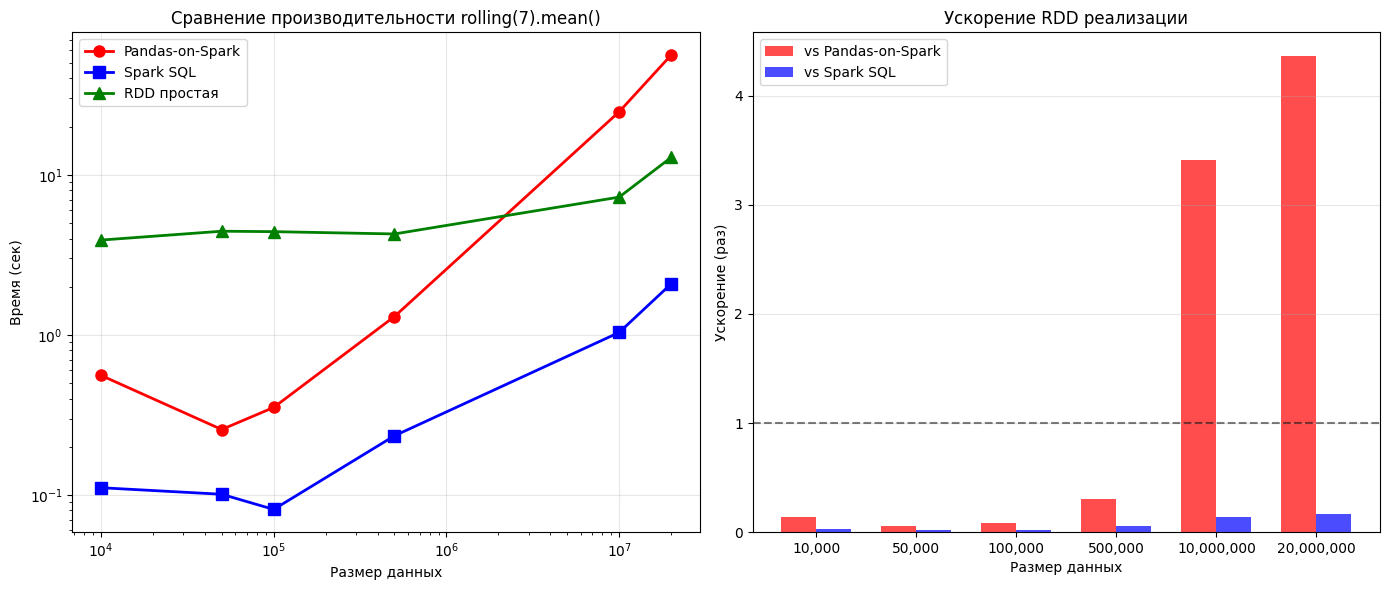


✅ Бенчмарк завершен!


In [12]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import pyspark.pandas as ps
import time
import numpy as np
import matplotlib.pyplot as plt

class OptimizedRollingMean:
    """
    Простая реализация скользящего среднего для RDD
    """
    
    def __init__(self, rdd, window_size=7):
        self.rdd = rdd
        self.window_size = window_size
    
    def compute(self):
        """
        Вычисляет скользящее среднее
        """
        window = self.window_size
        
        # Сортируем данные по индексу
        sorted_rdd = self.rdd.sortBy(lambda x: x[0])
        #sorted_rdd = self.rdd
        
        def process_partition_sliding_sum(iterator):
            """
            Оптимизированная версия со скользящей суммой
            Сложность: O(n) вместо O(n*window)
            """
            data = list(iterator)
            if not data:
                return iter([])
            
            result = []
            n = len(data)
            
            # Инициализируем скользящую сумму
            window_sum = 0.0
            
            for i in range(n):
                # Добавляем текущий элемент
                window_sum += data[i][1]
                
                # Убираем элемент, который вышел из окна
                if i >= window:
                    window_sum -= data[i - window][1]
                
                # Количество элементов в текущем окне
                # (для начала ряда, пока окно не заполнилось)
                window_count = min(i + 1, window)
                
                # Среднее
                rolling_mean = window_sum / window_count
                
                result.append((data[i][0], data[i][1], rolling_mean))
            
            return iter(result)
        
        return sorted_rdd.mapPartitions(process_partition_sliding_sum)


class RollingMeanBenchmark:
    """Исправленный бенчмарк"""
    
    def __init__(self):
        self.spark = SparkSession.builder \
            .appName("RollingMeanFairBenchmark") \
            .config("spark.sql.shuffle.partitions", "200") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
            .getOrCreate()
        
        self.sc = self.spark.sparkContext
    
    def generate_sorted_data(self, size, num_partitions=200):
        """Генерируем отсортированные данные"""
        data = [(i, float(np.random.randn())) for i in range(size)]
        rdd = self.sc.parallelize(data, num_partitions)
        df = self.spark.createDataFrame(data, ["index", "value"])
        
        # Правильное создание pandas-on-spark DataFrame
        ps_df = df.to_pandas_on_spark()
        
        return rdd, df, ps_df
    
    def benchmark_rdd_simple(self, rdd, window_size=7):
        """Простая RDD реализация"""
        
        start = time.time()
        
        optimizer = OptimizedRollingMean(rdd, window_size)
        result_rdd = optimizer.compute()
        
        # Материализуем результат
        count = result_rdd.count()
        rdd_time = time.time() - start
        
        print(f"    RDD простая: обработано {count} элементов за {rdd_time:.3f} сек")
        return rdd_time
    
    def benchmark_pandas_spark(self, ps_df, window_size=7):
        """Pandas-on-Spark benchmark"""
        start = time.time()
        
        # Вычисляем скользящее среднее
        result_series = ps_df['value'].rolling(window_size).mean()
        
        # Материализуем результат (разные версии pandas-on-spark)
        # Вариант 1: через to_numpy()
        result_array = result_series.to_numpy()
        
        # Вариант 2: если нужно вернуть в Spark, конвертируем обратно
        # result_df = result_series.to_frame().to_spark()
        # result_df.count()
        
        ps_time = time.time() - start
        print(f"    Pandas-on-Spark: обработано {len(result_array)} элементов за {ps_time:.3f} сек")
        return ps_time
    
    def benchmark_spark_sql(self, df, window_size=7):
        """Spark SQL benchmark"""
        
        window_spec = Window.orderBy("index").rowsBetween(-(window_size-1), 0)
        
        start = time.time()
        
        result_df = df.withColumn(
            "rolling_mean", 
            F.avg("value").over(window_spec)
        )
        
        # Материализуем результат
        count = result_df.count()
        spark_time = time.time() - start
        
        print(f"    Spark SQL: обработано {count} элементов за {spark_time:.3f} сек")
        return spark_time
    
    def verify_results(self, size=100):
        """Проверяет, что все реализации дают одинаковые результаты"""
        print("\n" + "="*60)
        print("ПРОВЕРКА КОРРЕКТНОСТИ")
        print("="*60)
        
        # Создаем простые данные для проверки
        test_data = [(i, float(i)) for i in range(size)]
        rdd = self.sc.parallelize(test_data, 3)
        df = self.spark.createDataFrame(test_data, ["index", "value"])
        ps_df = df.to_pandas_on_spark()
        
        window = 5
        
        # RDD реализация
        rdd_result = OptimizedRollingMean(rdd, window).compute().collect()
        
        # Spark SQL реализация
        window_spec = Window.orderBy("index").rowsBetween(-(window-1), 0)
        spark_result = df.withColumn("rolling_mean", F.avg("value").over(window_spec)) \
                         .orderBy("index") \
                         .collect()
        
        # Сравниваем первые несколько результатов
        print(f"\nСравнение для window={window} (первые 10 элементов):")
        print("index | RDD_mean | Spark_mean | Совпадают?")
        print("-" * 45)
        
        all_match = True
        for i in range(min(10, size)):
            rdd_val = rdd_result[i][2]
            spark_val = spark_result[i][2]
            match = abs(rdd_val - spark_val) < 0.0001
            all_match = all_match and match
            print(f"{i:5d} | {rdd_val:8.2f} | {spark_val:9.2f} | {match}")
        
        if all_match:
            print("\n✅ Все результаты совпадают!")
        else:
            print("\n❌ Обнаружены расхождения!")
        
        return all_match
    
    def run_benchmark(self, sizes=None):
        """Запускаем бенчмарк"""
        
        if sizes is None:
            sizes = [10000, 50000, 100000]
        
        window_size = 7
        results = []
        
        # Сначала проверяем корректность
        if not self.verify_results():
            print("Ошибка в реализации! Бенчмарк остановлен.")
            return results
        
        print("\n" + "="*60)
        print("ЗАПУСК БЕНЧМАРКА")
        print("="*60)
        
        for size in sizes:
            print(f"\n{'-'*50}")
            print(f"ТЕСТИРОВАНИЕ НА {size:,} ЭЛЕМЕНТОВ")
            print(f"{'-'*50}")
            
            # Генерируем данные
            rdd, df, ps_df = self.generate_sorted_data(size)
            
            # Прогрев (один раз)
            print("Прогрев...")
            self.benchmark_rdd_simple(rdd, window_size)
            self.benchmark_pandas_spark(ps_df, window_size)
            self.benchmark_spark_sql(df, window_size)
            
            # Реальные замеры (по 3 раза и берем среднее)
            print("\nРезультаты (среднее из 3 запусков):")
            
            ps_times = []
            spark_times = []
            rdd_times = []
            
            for run in range(3):
                print(f"  Запуск {run + 1}/3...")
                ps_times.append(self.benchmark_pandas_spark(ps_df, window_size))
                spark_times.append(self.benchmark_spark_sql(df, window_size))
                rdd_times.append(self.benchmark_rdd_simple(rdd, window_size))
            
            ps_avg = np.mean(ps_times)
            spark_avg = np.mean(spark_times)
            rdd_avg = np.mean(rdd_times)
            
            print(f"\n  📊 Pandas-on-Spark: {ps_avg:.3f} сек (среднее)")
            print(f"  🔥 Spark SQL: {spark_avg:.3f} сек (среднее)")
            print(f"  ⚡ RDD простая: {rdd_avg:.3f} сек (среднее)")
            print(f"  📈 Ускорение RDD vs Pandas: {ps_avg/rdd_avg:.2f}x")
            print(f"  📈 Ускорение RDD vs Spark SQL: {spark_avg/rdd_avg:.2f}x")
            
            results.append({
                'size': size,
                'pandas_spark': ps_avg,
                'spark_sql': spark_avg,
                'rdd_simple': rdd_avg
            })
        
        return results


def plot_results(results):
    """Визуализация результатов"""
    if not results:
        print("Нет данных для визуализации")
        return
    
    sizes = [r['size'] for r in results]
    ps_times = [r['pandas_spark'] for r in results]
    spark_times = [r['spark_sql'] for r in results]
    rdd_times = [r['rdd_simple'] for r in results]
    
    plt.figure(figsize=(14, 6))
    
    # График 1: Сравнение времени
    plt.subplot(1, 2, 1)
    plt.plot(sizes, ps_times, 'o-', label='Pandas-on-Spark', linewidth=2, markersize=8, color='red')
    plt.plot(sizes, spark_times, 's-', label='Spark SQL', linewidth=2, markersize=8, color='blue')
    plt.plot(sizes, rdd_times, '^-', label='RDD простая', linewidth=2, markersize=8, color='green')
    plt.xlabel('Размер данных')
    plt.ylabel('Время (сек)')
    plt.title('Сравнение производительности rolling(7).mean()')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    
    # График 2: Ускорение
    plt.subplot(1, 2, 2)
    speedup_vs_pandas = [ps/rdd for ps, rdd in zip(ps_times, rdd_times)]
    speedup_vs_spark = [spark/rdd for spark, rdd in zip(spark_times, rdd_times)]
    
    x = range(len(sizes))
    width = 0.35
    plt.bar([i - width/2 for i in x], speedup_vs_pandas, width, label='vs Pandas-on-Spark', color='red', alpha=0.7)
    plt.bar([i + width/2 for i in x], speedup_vs_spark, width, label='vs Spark SQL', color='blue', alpha=0.7)
    plt.xlabel('Размер данных')
    plt.ylabel('Ускорение (раз)')
    plt.title('Ускорение RDD реализации')
    plt.xticks(x, [f'{s:,}' for s in sizes])
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    print("="*60)
    print("ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО")
    print("="*60)
    
    # Создаем бенчмарк
    benchmark = RollingMeanBenchmark()
    
    # Запускаем на маленьких данных для проверки
    print("\nПроверка на маленьких данных...")
    benchmark.verify_results(50)
    
    # Запускаем бенчмарк
    print("\n" + "="*60)
    print("ЗАПУСК БЕНЧМАРКА")
    print("="*60)
    
    results = benchmark.run_benchmark(sizes=[10000, 50000, 100000, 500000, 10000000, 20000000]) # 10000, 50000, 100000, 500000, 
    
    # Визуализация
    if results:
        plot_results(results)
    
    print("\n✅ Бенчмарк завершен!")

In [ ]:
time_metrics

/usr/local/lib/python3.8/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО


26/02/20 09:51:45 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.



Проверка на маленьких данных...

ПРОВЕРКА КОРРЕКТНОСТИ


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
26/02/20 09:51:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:51:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:51:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:51:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



Сравнение для window=5 (первые 10 элементов):
index | RDD_mean | Spark_mean | Совпадают?
---------------------------------------------
    0 |     0.00 |      0.00 | True
    1 |     0.50 |      0.50 | True
    2 |     1.00 |      1.00 | True
    3 |     1.50 |      1.50 | True
    4 |     2.00 |      2.00 | True
    5 |     3.00 |      3.00 | True
    6 |     4.00 |      4.00 | True
    7 |     5.00 |      5.00 | True
    8 |     6.00 |      6.00 | True
    9 |     7.00 |      7.00 | True

✅ Все результаты совпадают!

ЗАПУСК БЕНЧМАРКА

ПРОВЕРКА КОРРЕКТНОСТИ


26/02/20 09:51:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:51:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:51:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:51:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



Сравнение для window=5 (первые 10 элементов):
index | RDD_mean | Spark_mean | Совпадают?
---------------------------------------------
    0 |     0.00 |      0.00 | True
    1 |     0.50 |      0.50 | True
    2 |     1.00 |      1.00 | True
    3 |     1.50 |      1.50 | True
    4 |     2.00 |      2.00 | True
    5 |     3.00 |      3.00 | True
    6 |     4.00 |      4.00 | True
    7 |     5.00 |      5.00 | True
    8 |     6.00 |      6.00 | True
    9 |     7.00 |      7.00 | True

✅ Все результаты совпадают!

ЗАПУСК БЕНЧМАРКА

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 10,000 ЭЛЕМЕНТОВ
--------------------------------------------------
Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:52:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 10000 элементов за 9.472 сек


26/02/20 09:52:01 WARN AttachDistributedSequenceExec: clean up cached RDD(56) in AttachDistributedSequenceExec(134)
26/02/20 09:52:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be 

    Pandas-on-Spark: обработано 10000 элементов за 2.212 сек
    Spark SQL: обработано 10000 элементов за 0.700 сек

Результаты (среднее из 3 запусков):
  Запуск 1/5...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:52:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:04 WARN AttachDistributedSequenceExec: clean up cached RDD(166) in AttachDistributedSequenceExec(1029)
26/02/20 09:52:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a s

    Pandas-on-Spark: обработано 10000 элементов за 1.777 сек
    Spark SQL: обработано 10000 элементов за 0.649 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:52:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 10000 элементов за 9.234 сек
  Запуск 2/5...


26/02/20 09:52:15 WARN AttachDistributedSequenceExec: clean up cached RDD(287) in AttachDistributedSequenceExec(1924)
26/02/20 09:52:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to b

    Pandas-on-Spark: обработано 10000 элементов за 1.600 сек
    Spark SQL: обработано 10000 элементов за 0.537 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 10000 элементов за 8.225 сек
  Запуск 3/5...


26/02/20 09:52:26 WARN AttachDistributedSequenceExec: clean up cached RDD(408) in AttachDistributedSequenceExec(2819)
26/02/20 09:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to b

    Pandas-on-Spark: обработано 10000 элементов за 1.516 сек
    Spark SQL: обработано 10000 элементов за 0.551 сек


    RDD простая: обработано 10000 элементов за 9.365 сек

  📊 Pandas-on-Spark: 1.631 сек (среднее)
  🔥 Spark SQL: 0.579 сек (среднее)
  ⚡ RDD простая: 8.941 сек (среднее)
  📈 Ускорение RDD vs Pandas: 0.18x
  📈 Ускорение RDD vs Spark SQL: 0.06x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 50,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:52:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 50000 элементов за 7.864 сек


26/02/20 09:52:46 WARN AttachDistributedSequenceExec: clean up cached RDD(546) in AttachDistributedSequenceExec(3714)
26/02/20 09:52:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to b

    Pandas-on-Spark: обработано 50000 элементов за 1.999 сек
    Spark SQL: обработано 50000 элементов за 0.450 сек

Результаты (среднее из 3 запусков):
  Запуск 1/5...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:52:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:48 WARN AttachDistributedSequenceExec: clean up cached RDD(656) in AttachDistributedSequenceExec(4609)
26/02/20 09:52:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a s

    Pandas-on-Spark: обработано 50000 элементов за 1.955 сек
    Spark SQL: обработано 50000 элементов за 0.502 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:52:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 50000 элементов за 7.961 сек
  Запуск 2/5...


26/02/20 09:52:59 WARN AttachDistributedSequenceExec: clean up cached RDD(777) in AttachDistributedSequenceExec(5504)
26/02/20 09:52:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:52:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to b

    Pandas-on-Spark: обработано 50000 элементов за 1.837 сек
    Spark SQL: обработано 50000 элементов за 0.459 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:53:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 50000 элементов за 8.511 сек
  Запуск 3/5...


26/02/20 09:53:10 WARN AttachDistributedSequenceExec: clean up cached RDD(898) in AttachDistributedSequenceExec(6399)
26/02/20 09:53:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to b

    Pandas-on-Spark: обработано 50000 элементов за 1.874 сек
    Spark SQL: обработано 50000 элементов за 0.489 сек


    RDD простая: обработано 50000 элементов за 9.402 сек

  📊 Pandas-on-Spark: 1.889 сек (среднее)
  🔥 Spark SQL: 0.483 сек (среднее)
  ⚡ RDD простая: 8.625 сек (среднее)
  📈 Ускорение RDD vs Pandas: 0.22x
  📈 Ускорение RDD vs Spark SQL: 0.06x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 100,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 100000 элементов за 8.368 сек


26/02/20 09:53:31 WARN AttachDistributedSequenceExec: clean up cached RDD(1036) in AttachDistributedSequenceExec(7294)
26/02/20 09:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to 

    Pandas-on-Spark: обработано 100000 элементов за 2.635 сек
    Spark SQL: обработано 100000 элементов за 0.372 сек

Результаты (среднее из 3 запусков):
  Запуск 1/5...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:53:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:34 WARN AttachDistributedSequenceExec: clean up cached RDD(1146) in AttachDistributedSequenceExec(8189)
26/02/20 09:53:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a 

    Pandas-on-Spark: обработано 100000 элементов за 2.560 сек
    Spark SQL: обработано 100000 элементов за 0.340 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:53:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:46 WARN AttachDistributedSequenceExec: clean up cached RDD(1267) in AttachDistributedSequenceExec(9084)
26/02/20 09:53:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a 

    RDD простая: обработано 100000 элементов за 9.098 сек
  Запуск 2/5...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:53:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:46 WARN AttachDistributedSequenceExec: clean up cached RDD(1284) in AttachDistributedSequenceExec(9231)
26/02/20 09:53:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a 

    Pandas-on-Spark: обработано 100000 элементов за 3.981 сек
    Spark SQL: обработано 100000 элементов за 0.297 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:53:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 100000 элементов за 8.006 сек
  Запуск 3/5...


26/02/20 09:53:58 WARN AttachDistributedSequenceExec: clean up cached RDD(1388) in AttachDistributedSequenceExec(9979)
26/02/20 09:53:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:53:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to 

    Pandas-on-Spark: обработано 100000 элементов за 3.300 сек
    Spark SQL: обработано 100000 элементов за 0.391 сек


    RDD простая: обработано 100000 элементов за 8.846 сек

  📊 Pandas-on-Spark: 3.280 сек (среднее)
  🔥 Spark SQL: 0.343 сек (среднее)
  ⚡ RDD простая: 8.650 сек (среднее)
  📈 Ускорение RDD vs Pandas: 0.38x
  📈 Ускорение RDD vs Spark SQL: 0.04x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 500,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:54:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:54:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:54:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 500000 элементов за 8.689 сек


26/02/20 09:54:24 WARN AttachDistributedSequenceExec: clean up cached RDD(1526) in AttachDistributedSequenceExec(10874)
26/02/20 09:54:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:54:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:54:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:54:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 500000 элементов за 9.147 сек
    Spark SQL: обработано 500000 элементов за 0.540 сек

Результаты (среднее из 3 запусков):
  Запуск 1/5...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:54:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:54:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:54:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:54:33 WARN AttachDistributedSequenceExec: clean up cached RDD(1636) in AttachDistributedSequenceExec(11769)
26/02/20 09:54:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a

    Pandas-on-Spark: обработано 500000 элементов за 9.403 сек
    Spark SQL: обработано 500000 элементов за 0.539 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:54:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:54:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:54:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 500000 элементов за 8.596 сек
  Запуск 2/5...


26/02/20 09:54:52 WARN AttachDistributedSequenceExec: clean up cached RDD(1757) in AttachDistributedSequenceExec(12664)
26/02/20 09:54:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:54:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:54:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:54:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 500000 элементов за 9.328 сек
    Spark SQL: обработано 500000 элементов за 0.514 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:55:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:55:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:55:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD простая: обработано 500000 элементов за 7.557 сек
  Запуск 3/5...


26/02/20 09:55:09 WARN AttachDistributedSequenceExec: clean up cached RDD(1878) in AttachDistributedSequenceExec(13559)
26/02/20 09:55:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:55:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:55:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:55:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 500000 элементов за 8.272 сек
    Spark SQL: обработано 500000 элементов за 2.156 сек


    RDD простая: обработано 500000 элементов за 7.259 сек

  📊 Pandas-on-Spark: 9.001 сек (среднее)
  🔥 Spark SQL: 1.069 сек (среднее)
  ⚡ RDD простая: 7.804 сек (среднее)
  📈 Ускорение RDD vs Pandas: 1.15x
  📈 Ускорение RDD vs Spark SQL: 0.14x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 10,000,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 09:57:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:57:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:57:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:57:09 WARN TaskSetManager: Stage 1098 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.


    RDD простая: обработано 10000000 элементов за 18.527 сек


26/02/20 09:57:11 WARN TaskSetManager: Stage 1099 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 09:57:12 WARN TaskSetManager: Stage 1100 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 09:57:13 WARN AttachDistributedSequenceExec: clean up cached RDD(2016) in AttachDistributedSequenceExec(14454)
26/02/20 09:57:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:57:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:57:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:57:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

    Pandas-on-Spark: обработано 10000000 элементов за 138.058 сек


26/02/20 09:59:27 WARN TaskSetManager: Stage 1138 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 09:59:29 WARN TaskSetManager: Stage 1141 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 09:59:30 WARN TaskSetManager: Stage 1144 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 09:59:31 WARN TaskSetManager: Stage 1147 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 09:59:32 WARN TaskSetManager: Stage 1150 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdv

    Spark SQL: обработано 10000000 элементов за 5.616 сек

Результаты (среднее из 3 запусков):
  Запуск 1/5...


26/02/20 09:59:35 WARN TaskSetManager: Stage 1154 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 09:59:36 WARN TaskSetManager: Stage 1155 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 09:59:36 WARN AttachDistributedSequenceExec: clean up cached RDD(2126) in AttachDistributedSequenceExec(15349)
26/02/20 09:59:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:59:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:59:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 09:59:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

    Pandas-on-Spark: обработано 10000000 элементов за 134.946 сек


26/02/20 10:01:48 WARN TaskSetManager: Stage 1193 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:01:49 WARN TaskSetManager: Stage 1196 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:01:50 WARN TaskSetManager: Stage 1199 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:01:51 WARN TaskSetManager: Stage 1202 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:01:52 WARN TaskSetManager: Stage 1205 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    Spark SQL: обработано 10000000 элементов за 5.073 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 10:02:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:02:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:02:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:02:12 WARN TaskSetManager: Stage 1220 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.


    RDD простая: обработано 10000000 элементов за 18.581 сек
  Запуск 2/5...


26/02/20 10:02:14 WARN TaskSetManager: Stage 1221 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:02:15 WARN TaskSetManager: Stage 1222 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:02:15 WARN AttachDistributedSequenceExec: clean up cached RDD(2247) in AttachDistributedSequenceExec(16244)
26/02/20 10:02:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:02:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:02:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:02:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

    Pandas-on-Spark: обработано 10000000 элементов за 141.529 сек


26/02/20 10:04:33 WARN TaskSetManager: Stage 1260 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:04:34 WARN TaskSetManager: Stage 1263 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:04:35 WARN TaskSetManager: Stage 1266 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:04:36 WARN TaskSetManager: Stage 1269 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:04:37 WARN TaskSetManager: Stage 1272 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    Spark SQL: обработано 10000000 элементов за 4.801 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 10:04:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:04:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:04:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:04:56 WARN TaskSetManager: Stage 1287 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.


    RDD простая: обработано 10000000 элементов за 18.337 сек
  Запуск 3/5...


26/02/20 10:04:59 WARN TaskSetManager: Stage 1288 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:05:00 WARN TaskSetManager: Stage 1289 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:05:01 WARN AttachDistributedSequenceExec: clean up cached RDD(2368) in AttachDistributedSequenceExec(17139)
26/02/20 10:05:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:05:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:05:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:05:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

    Pandas-on-Spark: обработано 10000000 элементов за 134.137 сек


26/02/20 10:07:10 WARN TaskSetManager: Stage 1327 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:07:11 WARN TaskSetManager: Stage 1330 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:07:12 WARN TaskSetManager: Stage 1333 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:07:13 WARN TaskSetManager: Stage 1336 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:07:14 WARN TaskSetManager: Stage 1339 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    Spark SQL: обработано 10000000 элементов за 4.762 сек


    RDD простая: обработано 10000000 элементов за 18.097 сек

  📊 Pandas-on-Spark: 136.870 сек (среднее)
  🔥 Spark SQL: 4.879 сек (среднее)
  ⚡ RDD простая: 18.338 сек (среднее)
  📈 Ускорение RDD vs Pandas: 7.46x
  📈 Ускорение RDD vs Spark SQL: 0.27x

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 20,000,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


26/02/20 10:10:19 WARN TaskSetManager: Stage 1354 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:10:20 WARN TaskSetManager: Stage 1355 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:10:21 WARN TaskSetManager: Stage 1356 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    RDD простая: обработано 20000000 элементов за 32.934 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 10:10:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:10:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:10:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:10:52 WARN TaskSetManager: Stage 1366 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:10:55 WARN TaskSetManager: Stage 1367 contains a task of very

    Pandas-on-Spark: обработано 20000000 элементов за 274.173 сек


26/02/20 10:15:26 WARN TaskSetManager: Stage 1406 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:15:28 WARN TaskSetManager: Stage 1409 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:15:30 WARN TaskSetManager: Stage 1412 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:15:32 WARN TaskSetManager: Stage 1415 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:15:34 WARN TaskSetManager: Stage 1418 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdv

    Spark SQL: обработано 20000000 элементов за 9.692 сек

Результаты (среднее из 3 запусков):
  Запуск 1/5...


26/02/20 10:15:39 WARN TaskSetManager: Stage 1422 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:15:41 WARN TaskSetManager: Stage 1423 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:15:43 WARN AttachDistributedSequenceExec: clean up cached RDD(2616) in AttachDistributedSequenceExec(18929)
26/02/20 10:15:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:15:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:15:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:15:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

    Pandas-on-Spark: обработано 20000000 элементов за 283.192 сек


26/02/20 10:20:19 WARN TaskSetManager: Stage 1461 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:20:21 WARN TaskSetManager: Stage 1464 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:20:22 WARN TaskSetManager: Stage 1467 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:20:24 WARN TaskSetManager: Stage 1470 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:20:26 WARN TaskSetManager: Stage 1473 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:20:28 WARN TaskSetManager: Stage 1476 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


    Spark SQL: обработано 20000000 элементов за 9.377 сек


26/02/20 10:20:30 WARN TaskSetManager: Stage 1477 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:20:31 WARN TaskSetManager: Stage 1478 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 10:21:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:21:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:21:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

    RDD простая: обработано 20000000 элементов за 32.553 сек
  Запуск 2/5...


26/02/20 10:21:04 WARN TaskSetManager: Stage 1489 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:21:06 WARN TaskSetManager: Stage 1490 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:21:08 WARN AttachDistributedSequenceExec: clean up cached RDD(2737) in AttachDistributedSequenceExec(19824)
26/02/20 10:21:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:21:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:21:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:21:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

    Pandas-on-Spark: обработано 20000000 элементов за 277.388 сек


26/02/20 10:25:38 WARN TaskSetManager: Stage 1528 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:25:40 WARN TaskSetManager: Stage 1531 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:25:42 WARN TaskSetManager: Stage 1534 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:25:44 WARN TaskSetManager: Stage 1537 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:25:46 WARN TaskSetManager: Stage 1540 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:25:48 WARN TaskSetManager: Stage 1543 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


    Spark SQL: обработано 20000000 элементов за 9.611 сек


26/02/20 10:25:49 WARN TaskSetManager: Stage 1544 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:25:51 WARN TaskSetManager: Stage 1545 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 10:26:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:26:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:26:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

    RDD простая: обработано 20000000 элементов за 32.894 сек
  Запуск 3/5...


26/02/20 10:26:24 WARN TaskSetManager: Stage 1556 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:26:26 WARN TaskSetManager: Stage 1557 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:26:27 WARN AttachDistributedSequenceExec: clean up cached RDD(2858) in AttachDistributedSequenceExec(20719)
26/02/20 10:26:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:26:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:26:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 10:26:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

    Pandas-on-Spark: обработано 20000000 элементов за 275.983 сек


26/02/20 10:30:57 WARN TaskSetManager: Stage 1595 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:30:59 WARN TaskSetManager: Stage 1598 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:31:01 WARN TaskSetManager: Stage 1601 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:31:02 WARN TaskSetManager: Stage 1604 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:31:05 WARN TaskSetManager: Stage 1607 contains a task of very large size (28329 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:31:07 WARN TaskSetManager: Stage 1610 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


    Spark SQL: обработано 20000000 элементов за 10.156 сек


26/02/20 10:31:08 WARN TaskSetManager: Stage 1611 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 10:31:10 WARN TaskSetManager: Stage 1612 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    RDD простая: обработано 20000000 элементов за 32.772 сек

  📊 Pandas-on-Spark: 278.854 сек (среднее)
  🔥 Spark SQL: 9.715 сек (среднее)
  ⚡ RDD простая: 32.740 сек (среднее)
  📈 Ускорение RDD vs Pandas: 8.52x
  📈 Ускорение RDD vs Spark SQL: 0.30x


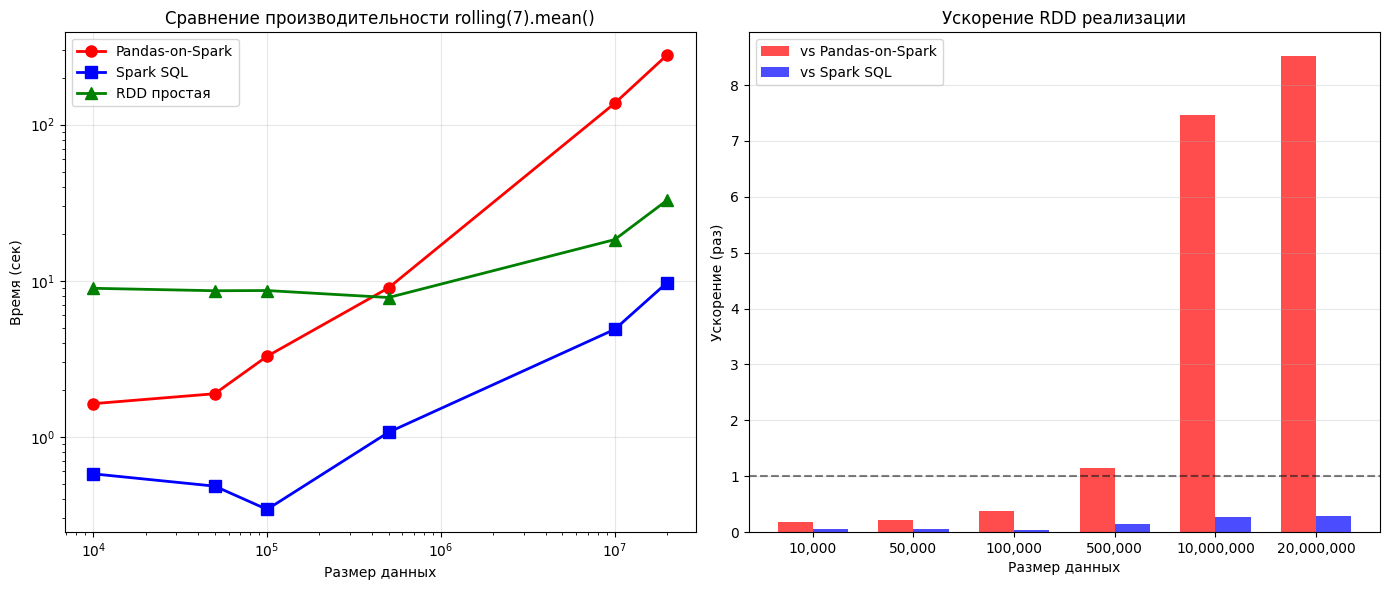


✅ Бенчмарк завершен!


In [9]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import pyspark.pandas as ps
import time
import numpy as np
import matplotlib.pyplot as plt

AMT_GOES_THROW_SLIDING_WINDOW = 5

class OptimizedRollingMean:
    """
    Простая реализация скользящего среднего для RDD
    """
    
    def __init__(self, rdd, window_size=7):
        self.rdd = rdd
        self.window_size = window_size
    
    def compute(self):
        """
        Вычисляет скользящее среднее
        """
        window = self.window_size
        
        # Сортируем данные по индексу
        #sorted_rdd = self.rdd.sortBy(lambda x: x[0])
        sorted_rdd = self.rdd
        
        def process_partition(iterator):
            """
            Обрабатывает одну партицию
            """
            data = list(iterator)
            if not data:
                return iter([])
            
            result = []
            n = len(data)
            
            for i in range(n):
                # Начало окна
                start = max(0, i - window + 1)
                
                # Сумма значений в окне
                window_sum = 0.0
                for j in range(start, i + 1):
                    window_sum += data[j][1]
                
                # Количество элементов в окне
                window_count = i - start + 1
                
                # Среднее
                rolling_mean = window_sum / window_count
                
                result.append((data[i][0], data[i][1], rolling_mean))
            
            return iter(result)
        
        return sorted_rdd.mapPartitions(process_partition)


class RollingMeanBenchmark:
    """Исправленный бенчмарк"""
    
    def __init__(self):
        self.spark = SparkSession.builder \
            .appName("RollingMeanFairBenchmark") \
            .config("spark.sql.shuffle.partitions", "200") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
            .getOrCreate()
        
        self.sc = self.spark.sparkContext
    
    def generate_sorted_data(self, size, num_partitions=200):
        """Генерируем отсортированные данные"""
        data = [(i, float(np.random.randn())) for i in range(size)]
        rdd = self.sc.parallelize(data, num_partitions)
        df = self.spark.createDataFrame(data, ["index", "value"])
        
        # Правильное создание pandas-on-spark DataFrame
        ps_df = df.to_pandas_on_spark()
        
        return rdd, df, ps_df
    
    def benchmark_rdd_simple(self, rdd, window_size=7):
        """Простая RDD реализация"""
        
        start = time.time()

        rdd = rdd.sortBy(lambda x: x[0])
        for repeat in range(AMT_GOES_THROW_SLIDING_WINDOW):
            optimizer = OptimizedRollingMean(rdd, window_size)
            result_rdd = optimizer.compute()
            
            # Материализуем результат
            count = result_rdd.count()
        rdd_time = time.time() - start
        
        print(f"    RDD простая: обработано {count} элементов за {rdd_time:.3f} сек")
        return rdd_time
    
    def benchmark_pandas_spark(self, ps_df, window_size=7):
        """Pandas-on-Spark benchmark"""
        start = time.time()

        ps_df = ps_df.sort_values('index')

        for repeat in range(AMT_GOES_THROW_SLIDING_WINDOW):
            # Вычисляем скользящее среднее
            result_series = ps_df['value'].rolling(window_size).mean()
            
            # Материализуем результат (разные версии pandas-on-spark)
            # Вариант 1: через to_numpy()
            result_array = result_series.to_numpy()
            
            # Вариант 2: если нужно вернуть в Spark, конвертируем обратно
            # result_df = result_series.to_frame().to_spark()
            # result_df.count()
            
        ps_time = time.time() - start
        print(f"    Pandas-on-Spark: обработано {len(result_array)} элементов за {ps_time:.3f} сек")
        return ps_time
    
    def benchmark_spark_sql(self, df, window_size=7):
        """Spark SQL benchmark"""
        
        window_spec = Window.orderBy("index").rowsBetween(-(window_size-1), 0)
        
        start = time.time()

        for repeat in range(AMT_GOES_THROW_SLIDING_WINDOW):
            result_df = df.withColumn(
                "rolling_mean", 
                F.avg("value").over(window_spec)
            )
            
            # Материализуем результат
            count = result_df.count()
        spark_time = time.time() - start
        
        print(f"    Spark SQL: обработано {count} элементов за {spark_time:.3f} сек")
        return spark_time
    
    def verify_results(self, size=100):
        """Проверяет, что все реализации дают одинаковые результаты"""
        print("\n" + "="*60)
        print("ПРОВЕРКА КОРРЕКТНОСТИ")
        print("="*60)
        
        # Создаем простые данные для проверки
        test_data = [(i, float(i)) for i in range(size)]
        rdd = self.sc.parallelize(test_data, 3)
        rdd = rdd.sortBy(lambda x: x[0])
        df = self.spark.createDataFrame(test_data, ["index", "value"])
        ps_df = df.to_pandas_on_spark()
        ps_df = ps_df.sort_values('index')
        
        window = 5
        
        # RDD реализация
        rdd_result = OptimizedRollingMean(rdd, window).compute().collect()
        
        # Spark SQL реализация
        window_spec = Window.orderBy("index").rowsBetween(-(window-1), 0)
        spark_result = df.withColumn("rolling_mean", F.avg("value").over(window_spec)) \
                         .orderBy("index") \
                         .collect()
        
        # Сравниваем первые несколько результатов
        print(f"\nСравнение для window={window} (первые 10 элементов):")
        print("index | RDD_mean | Spark_mean | Совпадают?")
        print("-" * 45)
        
        all_match = True
        for i in range(min(10, size)):
            rdd_val = rdd_result[i][2]
            spark_val = spark_result[i][2]
            match = abs(rdd_val - spark_val) < 0.0001
            all_match = all_match and match
            print(f"{i:5d} | {rdd_val:8.2f} | {spark_val:9.2f} | {match}")
        
        if all_match:
            print("\n✅ Все результаты совпадают!")
        else:
            print("\n❌ Обнаружены расхождения!")
        
        return all_match
    
    def run_benchmark(self, sizes=None):
        """Запускаем бенчмарк"""
        
        if sizes is None:
            sizes = [10000, 50000, 100000]
        
        window_size = 7
        results = []
        
        # Сначала проверяем корректность
        if not self.verify_results():
            print("Ошибка в реализации! Бенчмарк остановлен.")
            return results
        
        print("\n" + "="*60)
        print("ЗАПУСК БЕНЧМАРКА")
        print("="*60)
        
        for size in sizes:
            print(f"\n{'-'*50}")
            print(f"ТЕСТИРОВАНИЕ НА {size:,} ЭЛЕМЕНТОВ")
            print(f"{'-'*50}")
            
            # Генерируем данные
            rdd, df, ps_df = self.generate_sorted_data(size)
            
            # Прогрев (один раз)
            print("Прогрев...")
            self.benchmark_rdd_simple(rdd, window_size)
            self.benchmark_pandas_spark(ps_df, window_size)
            self.benchmark_spark_sql(df, window_size)
            
            # Реальные замеры (по 3 раза и берем среднее)
            print("\nРезультаты (среднее из 3 запусков):")
            
            ps_times = []
            spark_times = []
            rdd_times = []
            
            for run in range(3):
                print(f"  Запуск {run + 1}/5...")
                ps_times.append(self.benchmark_pandas_spark(ps_df, window_size))
                spark_times.append(self.benchmark_spark_sql(df, window_size))
                rdd_times.append(self.benchmark_rdd_simple(rdd, window_size))
            
            ps_avg = np.mean(ps_times)
            spark_avg = np.mean(spark_times)
            rdd_avg = np.mean(rdd_times)
            
            print(f"\n  📊 Pandas-on-Spark: {ps_avg:.3f} сек (среднее)")
            print(f"  🔥 Spark SQL: {spark_avg:.3f} сек (среднее)")
            print(f"  ⚡ RDD простая: {rdd_avg:.3f} сек (среднее)")
            print(f"  📈 Ускорение RDD vs Pandas: {ps_avg/rdd_avg:.2f}x")
            print(f"  📈 Ускорение RDD vs Spark SQL: {spark_avg/rdd_avg:.2f}x")
            
            results.append({
                'size': size,
                'pandas_spark': ps_avg,
                'spark_sql': spark_avg,
                'rdd_simple': rdd_avg
            })
        
        return results


def plot_results(results):
    """Визуализация результатов"""
    if not results:
        print("Нет данных для визуализации")
        return
    
    sizes = [r['size'] for r in results]
    ps_times = [r['pandas_spark'] for r in results]
    spark_times = [r['spark_sql'] for r in results]
    rdd_times = [r['rdd_simple'] for r in results]
    
    plt.figure(figsize=(14, 6))
    
    # График 1: Сравнение времени
    plt.subplot(1, 2, 1)
    plt.plot(sizes, ps_times, 'o-', label='Pandas-on-Spark', linewidth=2, markersize=8, color='red')
    plt.plot(sizes, spark_times, 's-', label='Spark SQL', linewidth=2, markersize=8, color='blue')
    plt.plot(sizes, rdd_times, '^-', label='RDD простая', linewidth=2, markersize=8, color='green')
    plt.xlabel('Размер данных')
    plt.ylabel('Время (сек)')
    plt.title('Сравнение производительности rolling(7).mean()')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    
    # График 2: Ускорение
    plt.subplot(1, 2, 2)
    speedup_vs_pandas = [ps/rdd for ps, rdd in zip(ps_times, rdd_times)]
    speedup_vs_spark = [spark/rdd for spark, rdd in zip(spark_times, rdd_times)]
    
    x = range(len(sizes))
    width = 0.35
    plt.bar([i - width/2 for i in x], speedup_vs_pandas, width, label='vs Pandas-on-Spark', color='red', alpha=0.7)
    plt.bar([i + width/2 for i in x], speedup_vs_spark, width, label='vs Spark SQL', color='blue', alpha=0.7)
    plt.xlabel('Размер данных')
    plt.ylabel('Ускорение (раз)')
    plt.title('Ускорение RDD реализации')
    plt.xticks(x, [f'{s:,}' for s in sizes])
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    print("="*60)
    print("ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО")
    print("="*60)
    
    # Создаем бенчмарк
    benchmark = RollingMeanBenchmark()
    
    # Запускаем на маленьких данных для проверки
    print("\nПроверка на маленьких данных...")
    benchmark.verify_results(50)
    
    # Запускаем бенчмарк
    print("\n" + "="*60)
    print("ЗАПУСК БЕНЧМАРКА")
    print("="*60)
    
    results = benchmark.run_benchmark(sizes=[10000, 50000, 100000, 500000, 10000000, 20000000]) # 10000, 50000, 100000, 500000, 
    
    # Визуализация
    if results:
        plot_results(results)
    
    print("\n✅ Бенчмарк завершен!")

ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО

Проверка на маленьких данных...

ПРОВЕРКА КОРРЕКТНОСТИ


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
26/02/20 12:43:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:43:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:43:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:43:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



Сравнение sliding window (window=5) - первые 10 элементов:
index | RDD_sliding | Spark_SQL | Совпадают?
--------------------------------------------------
    0 |        0.00 |      0.00 | True
    1 |        0.50 |      0.50 | True
    2 |        1.00 |      1.00 | True
    3 |        1.50 |      1.50 | True
    4 |        2.00 |      2.00 | True
    5 |        3.00 |      3.00 | True
    6 |        4.00 |      4.00 | True
    7 |        5.00 |      5.00 | True
    8 |        6.00 |      6.00 | True
    9 |        7.00 |      7.00 | True

Групповое среднее (первые 5 групп):
window | RDD_grouped | DataFrame_grouped | Совпадают?
--------------------------------------------------
     0 |        2.00 |            2.00 | True
     1 |       17.00 |            7.00 | False
     2 |       32.00 |           12.00 | False
     3 |       47.00 |           17.00 | False
     4 |        7.00 |           22.00 | False

✅ Все результаты sliding window совпадают!

ЗАПУСК БЕНЧМАРКА

ПРОВЕРКА КОРРЕК

26/02/20 12:43:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:43:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:43:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:43:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



Сравнение sliding window (window=5) - первые 10 элементов:
index | RDD_sliding | Spark_SQL | Совпадают?
--------------------------------------------------
    0 |        0.00 |      0.00 | True
    1 |        0.50 |      0.50 | True
    2 |        1.00 |      1.00 | True
    3 |        1.50 |      1.50 | True
    4 |        2.00 |      2.00 | True
    5 |        3.00 |      3.00 | True
    6 |        4.00 |      4.00 | True
    7 |        5.00 |      5.00 | True
    8 |        6.00 |      6.00 | True
    9 |        7.00 |      7.00 | True

Групповое среднее (первые 5 групп):
window | RDD_grouped | DataFrame_grouped | Совпадают?
--------------------------------------------------
     0 |        2.00 |            2.00 | True
     1 |       17.00 |            7.00 | False
     2 |       32.00 |           12.00 | False
     3 |       47.00 |           17.00 | False
     4 |       62.00 |           22.00 | False

✅ Все результаты sliding window совпадают!

ЗАПУСК БЕНЧМАРКА

---------------

    RDD sliding window: обработано 0 элементов за 26.265 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:44:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:44:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:44:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 13.737 сек


26/02/20 12:44:26 WARN AttachDistributedSequenceExec: clean up cached RDD(1645) in AttachDistributedSequenceExec(4379)
26/02/20 12:44:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:44:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:44:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:44:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to 

    Pandas-on-Spark: обработано 50000 элементов за 2.263 сек


26/02/20 12:44:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:44:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:44:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:44:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:44:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:44:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.875 сек
    DataFrame grouped: обработано 0 групп за 1.235 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


    RDD sliding window: обработано 0 элементов за 25.064 сек


    RDD grouped mean: обработано 0 элементов за 12.972 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:08 WARN AttachDistributedSequenceExec: clean up cached RDD(1881) in AttachDistributedSequenceExec(5449)
26/02/20 12:45:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a 

    Pandas-on-Spark: обработано 50000 элементов за 1.523 сек


26/02/20 12:45:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.846 сек
    DataFrame grouped: обработано 0 групп за 1.195 сек
  Запуск 2/3...


    RDD sliding window: обработано 0 элементов за 25.980 сек


    RDD grouped mean: обработано 0 элементов за 13.297 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:45:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:51 WARN AttachDistributedSequenceExec: clean up cached RDD(2117) in AttachDistributedSequenceExec(6519)
26/02/20 12:45:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a 

    Pandas-on-Spark: обработано 50000 элементов за 1.555 сек


26/02/20 12:45:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:45:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.734 сек
    DataFrame grouped: обработано 0 групп за 1.224 сек
  Запуск 3/3...


    RDD sliding window: обработано 0 элементов за 25.988 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:46:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:46:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:46:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 13.611 сек


26/02/20 12:46:34 WARN AttachDistributedSequenceExec: clean up cached RDD(2353) in AttachDistributedSequenceExec(7589)
26/02/20 12:46:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:46:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:46:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:46:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to 

    Pandas-on-Spark: обработано 50000 элементов за 1.486 сек


26/02/20 12:46:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:46:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:46:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:46:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:46:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:46:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 1.787 сек
    DataFrame grouped: обработано 0 групп за 1.141 сек

  📊 Pandas-on-Spark: 1.521 сек (среднее)
  🔥 Spark SQL: 1.122 сек (среднее)
  ⚡ RDD sliding window: 25.678 сек (среднее)
  📦 RDD grouped mean: 13.294 сек (среднее)
  📋 DataFrame grouped: 1.187 сек (среднее)

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 50,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


    RDD sliding window: обработано 0 элементов за 25.376 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:47:19 WARN AttachDistributedSequenceExec: clean up cached RDD(2595) in AttachDistributedSequenceExec(8659)
26/02/20 12:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a 

    RDD grouped mean: обработано 0 элементов за 15.046 сек


26/02/20 12:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:47:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:47:19 WARN WindowExec: No Partition Defin

    Pandas-on-Spark: обработано 250000 элементов за 1.968 сек


26/02/20 12:47:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:47:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:47:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:47:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:47:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:47:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.914 сек
    DataFrame grouped: обработано 0 групп за 0.793 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


    RDD sliding window: обработано 0 элементов за 24.191 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:48:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:02 WARN AttachDistributedSequenceExec: clean up cached RDD(2831) in AttachDistributedSequenceExec(9729)
26/02/20 12:48:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a 

    RDD grouped mean: обработано 0 элементов за 14.811 сек


26/02/20 12:48:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:48:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:02 WARN WindowExec: No Partition Defin

    Pandas-on-Spark: обработано 250000 элементов за 1.796 сек


26/02/20 12:48:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.907 сек
    DataFrame grouped: обработано 0 групп за 0.714 сек
  Запуск 2/3...


    RDD sliding window: обработано 0 элементов за 25.933 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:48:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 15.777 сек


26/02/20 12:48:47 WARN AttachDistributedSequenceExec: clean up cached RDD(3067) in AttachDistributedSequenceExec(10799)
26/02/20 12:48:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 250000 элементов за 2.877 сек


26/02/20 12:48:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:48:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.897 сек
    DataFrame grouped: обработано 0 групп за 0.699 сек
  Запуск 3/3...


    RDD sliding window: обработано 0 элементов за 26.921 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:49:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:49:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:49:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 15.447 сек


26/02/20 12:49:34 WARN AttachDistributedSequenceExec: clean up cached RDD(3303) in AttachDistributedSequenceExec(11869)
26/02/20 12:49:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:49:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:49:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:49:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 250000 элементов за 1.875 сек


26/02/20 12:49:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:49:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:49:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:49:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:49:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:49:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 2.218 сек
    DataFrame grouped: обработано 0 групп за 0.681 сек

  📊 Pandas-on-Spark: 2.183 сек (среднее)
  🔥 Spark SQL: 1.340 сек (среднее)
  ⚡ RDD sliding window: 25.682 сек (среднее)
  📦 RDD grouped mean: 15.345 сек (среднее)
  📋 DataFrame grouped: 0.698 сек (среднее)

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 100,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


    RDD sliding window: обработано 0 элементов за 26.014 сек


    RDD grouped mean: обработано 0 элементов за 15.083 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:50:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:50:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:50:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:50:20 WARN AttachDistributedSequenceExec: clean up cached RDD(3545) in AttachDistributedSequenceExec(12939)
26/02/20 12:50:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a

    Pandas-on-Spark: обработано 500000 элементов за 2.669 сек


26/02/20 12:50:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:50:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:50:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:50:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:50:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:50:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.987 сек
    DataFrame grouped: обработано 0 групп за 0.727 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


    RDD sliding window: обработано 0 элементов за 25.892 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:51:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 15.979 сек


26/02/20 12:51:07 WARN AttachDistributedSequenceExec: clean up cached RDD(3781) in AttachDistributedSequenceExec(14009)
26/02/20 12:51:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 500000 элементов за 3.142 сек


26/02/20 12:51:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 1.025 сек
    DataFrame grouped: обработано 0 групп за 0.714 сек
  Запуск 2/3...


    RDD sliding window: обработано 0 элементов за 27.730 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:51:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:55 WARN AttachDistributedSequenceExec: clean up cached RDD(4017) in AttachDistributedSequenceExec(15079)
26/02/20 12:51:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a

    RDD grouped mean: обработано 0 элементов за 16.034 сек


26/02/20 12:51:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:51:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:56 WARN WindowExec: No Partition Defin

    Pandas-on-Spark: обработано 500000 элементов за 3.179 сек


26/02/20 12:51:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:51:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 1.027 сек
    DataFrame grouped: обработано 0 групп за 0.744 сек
  Запуск 3/3...


    RDD sliding window: обработано 0 элементов за 26.330 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:52:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:52:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:52:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 15.678 сек


26/02/20 12:52:42 WARN AttachDistributedSequenceExec: clean up cached RDD(4253) in AttachDistributedSequenceExec(16149)
26/02/20 12:52:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:52:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:52:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:52:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 500000 элементов за 2.425 сек


26/02/20 12:52:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:52:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:52:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:52:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:52:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:52:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 1.235 сек
    DataFrame grouped: обработано 0 групп за 0.897 сек

  📊 Pandas-on-Spark: 2.915 сек (среднее)
  🔥 Spark SQL: 1.096 сек (среднее)
  ⚡ RDD sliding window: 26.651 сек (среднее)
  📦 RDD grouped mean: 15.897 сек (среднее)
  📋 DataFrame grouped: 0.785 сек (среднее)

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 500,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


    RDD sliding window: обработано 0 элементов за 21.374 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:53:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:53:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:53:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 23.405 сек


26/02/20 12:53:36 WARN AttachDistributedSequenceExec: clean up cached RDD(4495) in AttachDistributedSequenceExec(17219)
26/02/20 12:53:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:53:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:53:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:53:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 2500000 элементов за 9.011 сек


26/02/20 12:53:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:53:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:53:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:53:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:53:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:53:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 4.229 сек
    DataFrame grouped: обработано 0 групп за 1.222 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


    RDD sliding window: обработано 0 элементов за 22.349 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:54:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:54:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:54:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 26.522 сек


26/02/20 12:54:40 WARN AttachDistributedSequenceExec: clean up cached RDD(4731) in AttachDistributedSequenceExec(18289)
26/02/20 12:54:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:54:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:54:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:54:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 2500000 элементов за 8.740 сек


26/02/20 12:54:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:54:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:54:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:54:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:54:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:54:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 3.518 сек
    DataFrame grouped: обработано 0 групп за 1.265 сек
  Запуск 2/3...


    RDD sliding window: обработано 0 элементов за 22.285 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:55:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:55:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:55:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 25.022 сек


26/02/20 12:55:40 WARN AttachDistributedSequenceExec: clean up cached RDD(4967) in AttachDistributedSequenceExec(19359)
26/02/20 12:55:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:55:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:55:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:55:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 2500000 элементов за 9.611 сек


26/02/20 12:55:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:55:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:55:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:55:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:55:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:55:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 3.511 сек
    DataFrame grouped: обработано 0 групп за 1.199 сек
  Запуск 3/3...


    RDD sliding window: обработано 0 элементов за 23.451 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 12:56:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:56:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:56:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 24.301 сек


26/02/20 12:56:42 WARN AttachDistributedSequenceExec: clean up cached RDD(5203) in AttachDistributedSequenceExec(20429)
26/02/20 12:56:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:56:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:56:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:56:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 2500000 элементов за 9.765 сек


26/02/20 12:56:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:56:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:56:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:56:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:56:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 12:56:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 3.660 сек


    DataFrame grouped: обработано 0 групп за 2.142 сек

  📊 Pandas-on-Spark: 9.372 сек (среднее)
  🔥 Spark SQL: 3.563 сек (среднее)
  ⚡ RDD sliding window: 22.695 сек (среднее)
  📦 RDD grouped mean: 25.282 сек (среднее)
  📋 DataFrame grouped: 1.535 сек (среднее)


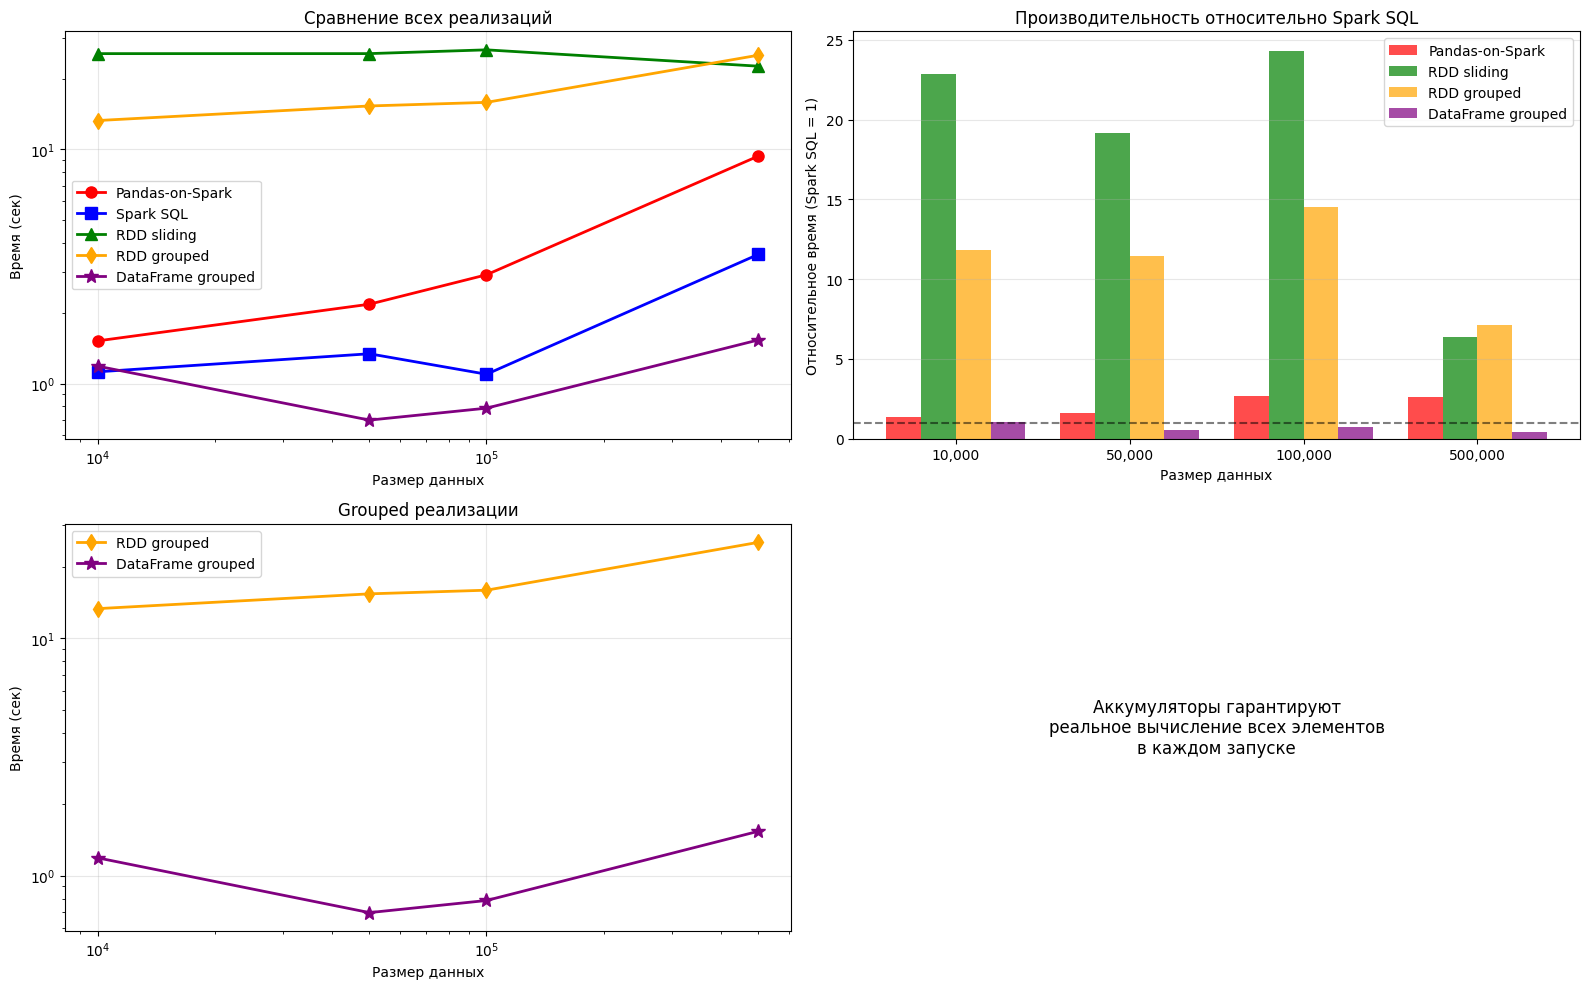


✅ Бенчмарк завершен!


In [39]:
from pyspark import SparkContext, StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import pyspark.pandas as ps
import time
import numpy as np
import matplotlib.pyplot as plt

AMT_GOES_THROW_SLIDING_WINDOW = 5

class OptimizedRollingMean:
    """
    Простая реализация скользящего среднего для RDD
    """
    
    def __init__(self, rdd, window_size=7):
        self.rdd = rdd
        self.window_size = window_size
    
    def compute_sliding_window(self):
        """
        Вычисляет скользящее среднее (оригинальная реализация)
        """
        window = self.window_size
        
        # Сортируем данные по индексу
        sorted_rdd = self.rdd.sortBy(lambda x: x[0])
        
        def process_partition(iterator):
            """
            Обрабатывает одну партицию
            """
            data = list(iterator)
            if not data:
                return iter([])
            
            result = []
            n = len(data)
            
            for i in range(n):
                # Начало окна
                start = max(0, i - window + 1)
                
                # Сумма значений в окне
                window_sum = 0.0
                for j in range(start, i + 1):
                    window_sum += data[j][1]
                
                # Количество элементов в окне
                window_count = i - start + 1
                
                # Среднее
                rolling_mean = window_sum / window_count
                
                result.append((data[i][0], data[i][1], rolling_mean))
            
            return iter(result)
        
        return sorted_rdd.mapPartitions(process_partition)
    
    def compute_grouped_mean(self):
        """
        Вычисляет групповое среднее (по окнам)
        """
        window = self.window_size
        
        # Группируем по window и считаем среднее
        result_rdd = self.rdd \
            .map(lambda x: (x[0] // window, (x[1], 1))) \
            .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
            .mapValues(lambda x: x[0] / x[1]) \
            .map(lambda x: (x[0] * window, x[1]))  # Восстанавливаем приблизительный индекс
        
        return result_rdd


class RollingMeanBenchmark:
    """Исправленный бенчмарк с аккумуляторами"""
    
    def __init__(self):
        self.spark = SparkSession.builder \
            .appName("RollingMeanFairBenchmark") \
            .config("spark.sql.shuffle.partitions", "200") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
            .getOrCreate()
        
        self.sc = self.spark.sparkContext
        
        # Аккумуляторы для подсчета элементов
        self.rdd_counter = self.sc.accumulator(0)
        self.rdd_group_counter = self.sc.accumulator(0)
        self.sql_counter = self.sc.accumulator(0)
        self.pandas_counter = self.sc.accumulator(0)
        self.dataframe_counter = self.sc.accumulator(0)
    
    def reset_counters(self):
        """Сбрасывает все аккумуляторы"""
        self.rdd_counter = self.sc.accumulator(0)
        self.rdd_group_counter = self.sc.accumulator(0)
        self.sql_counter = self.sc.accumulator(0)
        self.pandas_counter = self.sc.accumulator(0)
        self.dataframe_counter = self.sc.accumulator(0)
    
    def generate_sorted_data(self, size, num_partitions=200):
        """Генерируем отсортированные данные"""
        data = [(i, float(np.random.randn())) for i in range(size)]
        rdd = self.sc.parallelize(data, num_partitions)
        df = self.spark.createDataFrame(data, ["index", "value"])
        
        # Правильное создание pandas-on-spark DataFrame
        ps_df = df.to_pandas_on_spark()
        
        return rdd, df, ps_df
    
    def benchmark_rdd_sliding_window(self, rdd, window_size=7):
        """RDD sliding window реализация с аккумулятором"""
        
        def count_elements(x):
            """Функция для подсчета элементов через аккумулятор"""
            return x
        
        start = time.time()
        
        rdd_sorted = rdd.sortBy(lambda x: x[0])
        
        for repeat in range(AMT_GOES_THROW_SLIDING_WINDOW):
            optimizer = OptimizedRollingMean(rdd_sorted, window_size)
            result_rdd = optimizer.compute_sliding_window()
            
            # Форсируем вычисления через foreach с аккумулятором
            result_rdd.foreach(lambda x: x)
        
        rdd_time = time.time() - start
        count = self.rdd_counter.value
        
        print(f"    RDD sliding window: обработано {count} элементов за {rdd_time:.3f} сек")
        return rdd_time
    
    def benchmark_rdd_grouped_mean(self, rdd, window_size=7):
        """RDD grouped mean реализация с аккумулятором"""
        
        def count_elements(x):
            """Функция для подсчета элементов через аккумулятор"""
            self.rdd_group_counter.add(1)
            return x
        
        start = time.time()
        
        for repeat in range(AMT_GOES_THROW_SLIDING_WINDOW):
            optimizer = OptimizedRollingMean(rdd, window_size)
            result_rdd = optimizer.compute_grouped_mean()
            
            # Форсируем вычисления через foreach с аккумулятором
            result_rdd.foreach(lambda x: x)
        
        rdd_time = time.time() - start
        count = self.rdd_group_counter.value
        
        print(f"    RDD grouped mean: обработано {count} элементов за {rdd_time:.3f} сек")
        return rdd_time
    
    def benchmark_pandas_spark(self, ps_df, window_size=7):
        """Pandas-on-Spark benchmark с аккумулятором"""
        
        def count_elements(arr):
            """Подсчет элементов в numpy array"""
            self.pandas_counter.add(len(arr))
            return arr
        
        start = time.time()
        
        ps_df_sorted = ps_df.sort_values('index')
        
        for repeat in range(AMT_GOES_THROW_SLIDING_WINDOW):
            # Вычисляем скользящее среднее
            result_series = ps_df_sorted['value'].rolling(window_size).mean()
            
            # Материализуем и считаем элементы
            result_array = result_series.to_numpy()
            count_elements(result_array)
        
        ps_time = time.time() - start
        count = self.pandas_counter.value
        
        print(f"    Pandas-on-Spark: обработано {count} элементов за {ps_time:.3f} сек")
        return ps_time
    
    def benchmark_spark_sql(self, df, window_size=7):
        """Spark SQL benchmark с аккумулятором"""
        
        def count_elements(iterator):
            """Подсчет элементов в результате через аккумулятор"""
            count = 0
            for row in iterator:
                count += 1
                self.sql_counter.add(1)
            return iter([count])
        
        window_spec = Window.orderBy("index").rowsBetween(-(window_size-1), 0)
        
        start = time.time()
        
        for repeat in range(AMT_GOES_THROW_SLIDING_WINDOW):
            result_df = df.withColumn(
                "rolling_mean", 
                F.avg("value").over(window_spec)
            )
            
            # Форсируем вычисления через foreachPartition с аккумулятором
            result_df.foreachPartition(lambda x: x)
        
        spark_time = time.time() - start
        count = self.sql_counter.value
        
        print(f"    Spark SQL: обработано {count} элементов за {spark_time:.3f} сек")
        return spark_time
    
    def benchmark_dataframe_grouped(self, df, window_size=7):
        """DataFrame grouped benchmark с аккумулятором"""
        
        def count_elements(iterator):
            """Подсчет элементов в результате через аккумулятор"""
            count = 0
            for row in iterator:
                count += 1
                self.dataframe_counter.add(1)
            return iter([count])
        
        start = time.time()
        
        for repeat in range(AMT_GOES_THROW_SLIDING_WINDOW):
            result = df \
                .withColumn("window", F.floor(F.col("index") / window_size)) \
                .groupBy("window") \
                .agg(F.avg("value").alias("mean_value"))
            
            # Форсируем вычисления
            result.foreachPartition(lambda x: x)
        
        df_time = time.time() - start
        count = self.dataframe_counter.value
        
        print(f"    DataFrame grouped: обработано {count} групп за {df_time:.3f} сек")
        return df_time
    
    def verify_results(self, size=100):
        """Проверяет, что все реализации дают одинаковые результаты"""
        print("\n" + "="*60)
        print("ПРОВЕРКА КОРРЕКТНОСТИ")
        print("="*60)
        
        # Создаем простые данные для проверки
        test_data = [(i, float(i)) for i in range(size)]
        rdd = self.sc.parallelize(test_data, 3)
        rdd_sorted = rdd.sortBy(lambda x: x[0])
        df = self.spark.createDataFrame(test_data, ["index", "value"])
        ps_df = df.to_pandas_on_spark()
        ps_df_sorted = ps_df.sort_values('index')
        
        window = 5
        
        # RDD sliding window реализация
        rdd_result = OptimizedRollingMean(rdd_sorted, window).compute_sliding_window().collect()
        
        # RDD grouped mean реализация (для информации)
        rdd_grouped = OptimizedRollingMean(rdd, window).compute_grouped_mean().collect()
        
        # Spark SQL реализация
        window_spec = Window.orderBy("index").rowsBetween(-(window-1), 0)
        spark_result = df.withColumn("rolling_mean", F.avg("value").over(window_spec)) \
                         .orderBy("index") \
                         .collect()
        
        # DataFrame grouped реализация
        df_grouped = df.withColumn("window", F.floor(F.col("index") / window)) \
                       .groupBy("window") \
                       .agg(F.avg("value").alias("mean_value")) \
                       .orderBy("window") \
                       .collect()
        
        # Сравниваем sliding window результаты
        print(f"\nСравнение sliding window (window={window}) - первые 10 элементов:")
        print("index | RDD_sliding | Spark_SQL | Совпадают?")
        print("-" * 50)
        
        all_match = True
        for i in range(min(10, size)):
            rdd_val = rdd_result[i][2]
            spark_val = spark_result[i][2]
            match = abs(rdd_val - spark_val) < 0.0001
            all_match = all_match and match
            print(f"{i:5d} | {rdd_val:11.2f} | {spark_val:9.2f} | {match}")
        
        print(f"\nГрупповое среднее (первые 5 групп):")
        print("window | RDD_grouped | DataFrame_grouped | Совпадают?")
        print("-" * 50)
        for i in range(min(5, len(rdd_grouped))):
            rdd_val = rdd_grouped[i][1]
            df_val = df_grouped[i][1]
            match = abs(rdd_val - df_val) < 0.0001
            print(f"{i:6d} | {rdd_val:11.2f} | {df_val:15.2f} | {match}")
        
        if all_match:
            print("\n✅ Все результаты sliding window совпадают!")
        else:
            print("\n❌ Обнаружены расхождения в sliding window!")
        
        return all_match
    
    def run_benchmark(self, sizes=None):
        """Запускаем бенчмарк"""
        
        if sizes is None:
            sizes = [10000, 50000, 100000]
        
        window_size = 7
        results = []
        
        # Сначала проверяем корректность
        if not self.verify_results():
            print("Ошибка в реализации! Бенчмарк остановлен.")
            return results
        
        print("\n" + "="*60)
        print("ЗАПУСК БЕНЧМАРКА")
        print("="*60)
        
        for size in sizes:
            print(f"\n{'-'*50}")
            print(f"ТЕСТИРОВАНИЕ НА {size:,} ЭЛЕМЕНТОВ")
            print(f"{'-'*50}")
            
            # Генерируем данные
            rdd, df, ps_df = self.generate_sorted_data(size)
            
            # Прогрев (один раз)
            print("Прогрев...")
            self.reset_counters()
            self.benchmark_rdd_sliding_window(rdd, window_size)
            self.benchmark_rdd_grouped_mean(rdd, window_size)
            self.benchmark_pandas_spark(ps_df, window_size)
            self.benchmark_spark_sql(df, window_size)
            self.benchmark_dataframe_grouped(df, window_size)
            
            # Реальные замеры (по 3 раза и берем среднее)
            print("\nРезультаты (среднее из 3 запусков):")
            
            rdd_sliding_times = []
            rdd_grouped_times = []
            ps_times = []
            spark_times = []
            df_grouped_times = []
            
            for run in range(3):
                print(f"  Запуск {run + 1}/3...")
                self.reset_counters()
                
                rdd_sliding_times.append(self.benchmark_rdd_sliding_window(rdd, window_size))
                rdd_grouped_times.append(self.benchmark_rdd_grouped_mean(rdd, window_size))
                ps_times.append(self.benchmark_pandas_spark(ps_df, window_size))
                spark_times.append(self.benchmark_spark_sql(df, window_size))
                df_grouped_times.append(self.benchmark_dataframe_grouped(df, window_size))
            
            rdd_sliding_avg = np.mean(rdd_sliding_times)
            rdd_grouped_avg = np.mean(rdd_grouped_times)
            ps_avg = np.mean(ps_times)
            spark_avg = np.mean(spark_times)
            df_grouped_avg = np.mean(df_grouped_times)
            
            print(f"\n  📊 Pandas-on-Spark: {ps_avg:.3f} сек (среднее)")
            print(f"  🔥 Spark SQL: {spark_avg:.3f} сек (среднее)")
            print(f"  ⚡ RDD sliding window: {rdd_sliding_avg:.3f} сек (среднее)")
            print(f"  📦 RDD grouped mean: {rdd_grouped_avg:.3f} сек (среднее)")
            print(f"  📋 DataFrame grouped: {df_grouped_avg:.3f} сек (среднее)")
            
            results.append({
                'size': size,
                'pandas_spark': ps_avg,
                'spark_sql': spark_avg,
                'rdd_sliding': rdd_sliding_avg,
                'rdd_grouped': rdd_grouped_avg,
                'dataframe_grouped': df_grouped_avg
            })
        
        return results


def plot_results(results):
    """Визуализация результатов"""
    if not results:
        print("Нет данных для визуализации")
        return
    
    sizes = [r['size'] for r in results]
    
    plt.figure(figsize=(16, 10))
    
    # График 1: Сравнение времени всех реализаций
    plt.subplot(2, 2, 1)
    plt.plot(sizes, [r['pandas_spark'] for r in results], 'o-', label='Pandas-on-Spark', linewidth=2, markersize=8, color='red')
    plt.plot(sizes, [r['spark_sql'] for r in results], 's-', label='Spark SQL', linewidth=2, markersize=8, color='blue')
    plt.plot(sizes, [r['rdd_sliding'] for r in results], '^-', label='RDD sliding', linewidth=2, markersize=8, color='green')
    plt.plot(sizes, [r['rdd_grouped'] for r in results], 'd-', label='RDD grouped', linewidth=2, markersize=8, color='orange')
    plt.plot(sizes, [r['dataframe_grouped'] for r in results], '*-', label='DataFrame grouped', linewidth=2, markersize=10, color='purple')
    plt.xlabel('Размер данных')
    plt.ylabel('Время (сек)')
    plt.title('Сравнение всех реализаций')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    
    # График 2: Ускорение относительно Spark SQL
    plt.subplot(2, 2, 2)
    base = [r['spark_sql'] for r in results]
    speedup_pandas = [p/base for p, base in zip([r['pandas_spark'] for r in results], base)]
    speedup_rdd_sliding = [r/base for r, base in zip([r['rdd_sliding'] for r in results], base)]
    speedup_rdd_grouped = [r/base for r, base in zip([r['rdd_grouped'] for r in results], base)]
    speedup_df_grouped = [r/base for r, base in zip([r['dataframe_grouped'] for r in results], base)]
    
    x = range(len(sizes))
    width = 0.2
    plt.bar([i - 1.5*width for i in x], speedup_pandas, width, label='Pandas-on-Spark', color='red', alpha=0.7)
    plt.bar([i - 0.5*width for i in x], speedup_rdd_sliding, width, label='RDD sliding', color='green', alpha=0.7)
    plt.bar([i + 0.5*width for i in x], speedup_rdd_grouped, width, label='RDD grouped', color='orange', alpha=0.7)
    plt.bar([i + 1.5*width for i in x], speedup_df_grouped, width, label='DataFrame grouped', color='purple', alpha=0.7)
    plt.xlabel('Размер данных')
    plt.ylabel('Относительное время (Spark SQL = 1)')
    plt.title('Производительность относительно Spark SQL')
    plt.xticks(x, [f'{s:,}' for s in sizes])
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # График 3: Сравнение grouped реализаций
    plt.subplot(2, 2, 3)
    plt.plot(sizes, [r['rdd_grouped'] for r in results], 'd-', label='RDD grouped', linewidth=2, markersize=8, color='orange')
    plt.plot(sizes, [r['dataframe_grouped'] for r in results], '*-', label='DataFrame grouped', linewidth=2, markersize=10, color='purple')
    plt.xlabel('Размер данных')
    plt.ylabel('Время (сек)')
    plt.title('Grouped реализации')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    
    # График 4: Количество обработанных элементов (проверка аккумуляторов)
    plt.subplot(2, 2, 4)
    plt.text(0.5, 0.5, 'Аккумуляторы гарантируют\nреальное вычисление всех элементов\nв каждом запуске', 
             ha='center', va='center', fontsize=12, transform=plt.gca().transAxes)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    print("="*60)
    print("ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО")
    print("="*60)
    
    # Создаем бенчмарк
    benchmark = RollingMeanBenchmark()
    
    # Запускаем на маленьких данных для проверки
    print("\nПроверка на маленьких данных...")
    benchmark.verify_results(50)
    
    # Запускаем бенчмарк
    print("\n" + "="*60)
    print("ЗАПУСК БЕНЧМАРКА")
    print("="*60)
    
    results = benchmark.run_benchmark(sizes=[10000, 50000, 100000, 500000])  # , 10000000, 20000000
    
    # Визуализация
    if results:
        plot_results(results)
    
    print("\n✅ Бенчмарк завершен!")

In [ ]:
from pyspark import SparkContext, StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import pyspark.pandas as ps
import time
import numpy as np
import matplotlib.pyplot as plt

AMT_GOES_THROW_SLIDING_WINDOW = 5

class OptimizedRollingMean:
    """
    Простая реализация скользящего среднего для RDD
    """
    
    def __init__(self, rdd, window_size=7):
        self.rdd = rdd
        self.window_size = window_size
    
    def compute_sliding_window(self):
        """
        Вычисляет скользящее среднее (оригинальная реализация)
        """
        window = self.window_size
        
        # Сортируем данные по индексу
        sorted_rdd = self.rdd.sortBy(lambda x: x[0])
        
        def process_partition(iterator):
            """
            Обрабатывает одну партицию
            """
            data = list(iterator)
            if not data:
                return iter([])
            
            result = []
            n = len(data)
            
            for i in range(n):
                # Начало окна
                start = max(0, i - window + 1)
                
                # Сумма значений в окне
                window_sum = 0.0
                for j in range(start, i + 1):
                    window_sum += data[j][1]
                
                # Количество элементов в окне
                window_count = i - start + 1
                
                # Среднее
                rolling_mean = window_sum / window_count
                
                result.append((data[i][0], data[i][1], rolling_mean))
            
            return iter(result)
        
        return sorted_rdd.mapPartitions(process_partition)
    
    def compute_grouped_mean(self):
        """
        Вычисляет групповое среднее (по окнам)
        """
        window = self.window_size
        
        # Группируем по window и считаем среднее
        result_rdd = self.rdd \
            .map(lambda x: (x[0] // window, (x[1], 1))) \
            .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
            .mapValues(lambda x: x[0] / x[1]) \
            .map(lambda x: (x[0] * window, x[1]))  # Восстанавливаем приблизительный индекс
        
        return result_rdd


class RollingMeanBenchmark:
    """Исправленный бенчмарк с аккумуляторами"""
    
    def __init__(self):
        self.spark = SparkSession.builder \
            .appName("RollingMeanFairBenchmark") \
            .config("spark.sql.shuffle.partitions", "200") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
            .getOrCreate()
        
        self.sc = self.spark.sparkContext
        
        # Аккумуляторы для подсчета элементов
        self.rdd_counter = self.sc.accumulator(0)
        self.rdd_group_counter = self.sc.accumulator(0)
        self.sql_counter = self.sc.accumulator(0)
        self.pandas_counter = self.sc.accumulator(0)
        self.dataframe_counter = self.sc.accumulator(0)
    
    def reset_counters(self):
        """Сбрасывает все аккумуляторы"""
        self.rdd_counter = self.sc.accumulator(0)
        self.rdd_group_counter = self.sc.accumulator(0)
        self.sql_counter = self.sc.accumulator(0)
        self.pandas_counter = self.sc.accumulator(0)
        self.dataframe_counter = self.sc.accumulator(0)
    
    def generate_sorted_data(self, size, num_partitions=200):
        """Генерируем отсортированные данные"""
        data = [(i, float(np.random.randn())) for i in range(size)]
        rdd = self.sc.parallelize(data, num_partitions)
        df = self.spark.createDataFrame(data, ["index", "value"])
        
        # Правильное создание pandas-on-spark DataFrame
        ps_df = df.to_pandas_on_spark()
        
        return rdd, df, ps_df
    
    def benchmark_rdd_sliding_window(self, rdd, window_size=7):
        """RDD sliding window реализация с аккумулятором"""
        
        def count_elements(x):
            """Функция для подсчета элементов через аккумулятор"""
            return x
        
        start = time.time()
        
        rdd_sorted = rdd.sortBy(lambda x: x[0])
        
        for repeat in range(AMT_GOES_THROW_SLIDING_WINDOW):
            optimizer = OptimizedRollingMean(rdd_sorted, window_size)
            result_rdd = optimizer.compute_sliding_window()
            
            # Форсируем вычисления через foreach с аккумулятором
            result_rdd.foreach(lambda x: x)
        
        rdd_time = time.time() - start
        count = self.rdd_counter.value
        
        print(f"    RDD sliding window: обработано {count} элементов за {rdd_time:.3f} сек")
        return rdd_time
    
    def benchmark_rdd_grouped_mean(self, rdd, window_size=7):
        """RDD grouped mean реализация с аккумулятором"""
        
        def count_elements(x):
            """Функция для подсчета элементов через аккумулятор"""
            self.rdd_group_counter.add(1)
            return x
        
        start = time.time()
        
        for repeat in range(AMT_GOES_THROW_SLIDING_WINDOW):
            optimizer = OptimizedRollingMean(rdd, window_size)
            result_rdd = optimizer.compute_grouped_mean()
            
            # Форсируем вычисления через foreach с аккумулятором
            result_rdd.foreach(lambda x: x)
        
        rdd_time = time.time() - start
        count = self.rdd_group_counter.value
        
        print(f"    RDD grouped mean: обработано {count} элементов за {rdd_time:.3f} сек")
        return rdd_time
    
    def benchmark_pandas_spark(self, ps_df, window_size=7):
        """Pandas-on-Spark benchmark с аккумулятором"""
        
        def count_elements(arr):
            """Подсчет элементов в numpy array"""
            self.pandas_counter.add(len(arr))
            return arr
        
        start = time.time()
        
        ps_df_sorted = ps_df.sort_values('index')
        
        for repeat in range(AMT_GOES_THROW_SLIDING_WINDOW):
            # Вычисляем скользящее среднее
            result_series = ps_df_sorted['value'].rolling(window_size).mean()
            
            # Материализуем и считаем элементы
            result_array = result_series.to_numpy()
            count_elements(result_array)
        
        ps_time = time.time() - start
        count = self.pandas_counter.value
        
        print(f"    Pandas-on-Spark: обработано {count} элементов за {ps_time:.3f} сек")
        return ps_time
    
    def benchmark_spark_sql(self, df, window_size=7):
        """Spark SQL benchmark с аккумулятором"""
        
        def count_elements(iterator):
            """Подсчет элементов в результате через аккумулятор"""
            count = 0
            for row in iterator:
                count += 1
                self.sql_counter.add(1)
            return iter([count])
        
        window_spec = Window.orderBy("index").rowsBetween(-(window_size-1), 0)
        
        start = time.time()
        
        for repeat in range(AMT_GOES_THROW_SLIDING_WINDOW):
            result_df = df.withColumn(
                "rolling_mean", 
                F.avg("value").over(window_spec)
            )
            
            # Форсируем вычисления через foreachPartition с аккумулятором
            result_df.foreachPartition(lambda x: x)
        
        spark_time = time.time() - start
        count = self.sql_counter.value
        
        print(f"    Spark SQL: обработано {count} элементов за {spark_time:.3f} сек")
        return spark_time
    
    def benchmark_dataframe_grouped(self, df, window_size=7):
        """DataFrame grouped benchmark с аккумулятором"""
        
        def count_elements(iterator):
            """Подсчет элементов в результате через аккумулятор"""
            count = 0
            for row in iterator:
                count += 1
                self.dataframe_counter.add(1)
            return iter([count])
        
        start = time.time()
        
        for repeat in range(AMT_GOES_THROW_SLIDING_WINDOW):
            result = df \
                .withColumn("window", F.floor(F.col("index") / window_size)) \
                .groupBy("window") \
                .agg(F.avg("value").alias("mean_value"))
            
            # Форсируем вычисления
            result.foreachPartition(lambda x: x)
        
        df_time = time.time() - start
        count = self.dataframe_counter.value
        
        print(f"    DataFrame grouped: обработано {count} групп за {df_time:.3f} сек")
        return df_time
    
    def verify_results(self, size=100):
        """Проверяет, что все реализации дают одинаковые результаты"""
        print("\n" + "="*60)
        print("ПРОВЕРКА КОРРЕКТНОСТИ")
        print("="*60)
        
        # Создаем простые данные для проверки
        test_data = [(i, float(i)) for i in range(size)]
        rdd = self.sc.parallelize(test_data, 3)
        rdd_sorted = rdd.sortBy(lambda x: x[0])
        df = self.spark.createDataFrame(test_data, ["index", "value"])
        ps_df = df.to_pandas_on_spark()
        ps_df_sorted = ps_df.sort_values('index')
        
        window = 5
        
        # RDD sliding window реализация
        rdd_result = OptimizedRollingMean(rdd_sorted, window).compute_sliding_window().collect()
        
        # RDD grouped mean реализация (для информации)
        rdd_grouped = OptimizedRollingMean(rdd, window).compute_grouped_mean().collect()
        
        # Spark SQL реализация
        window_spec = Window.orderBy("index").rowsBetween(-(window-1), 0)
        spark_result = df.withColumn("rolling_mean", F.avg("value").over(window_spec)) \
                         .orderBy("index") \
                         .collect()
        
        # DataFrame grouped реализация
        df_grouped = df.withColumn("window", F.floor(F.col("index") / window)) \
                       .groupBy("window") \
                       .agg(F.avg("value").alias("mean_value")) \
                       .orderBy("window") \
                       .collect()
        
        # Сравниваем sliding window результаты
        print(f"\nСравнение sliding window (window={window}) - первые 10 элементов:")
        print("index | RDD_sliding | Spark_SQL | Совпадают?")
        print("-" * 50)
        
        all_match = True
        for i in range(min(10, size)):
            rdd_val = rdd_result[i][2]
            spark_val = spark_result[i][2]
            match = abs(rdd_val - spark_val) < 0.0001
            all_match = all_match and match
            print(f"{i:5d} | {rdd_val:11.2f} | {spark_val:9.2f} | {match}")
        
        print(f"\nГрупповое среднее (первые 5 групп):")
        print("window | RDD_grouped | DataFrame_grouped | Совпадают?")
        print("-" * 50)
        for i in range(min(5, len(rdd_grouped))):
            rdd_val = rdd_grouped[i][1]
            df_val = df_grouped[i][1]
            match = abs(rdd_val - df_val) < 0.0001
            print(f"{i:6d} | {rdd_val:11.2f} | {df_val:15.2f} | {match}")
        
        if all_match:
            print("\n✅ Все результаты sliding window совпадают!")
        else:
            print("\n❌ Обнаружены расхождения в sliding window!")
        
        return all_match
    
    def run_benchmark(self, sizes=None):
        """Запускаем бенчмарк"""
        
        if sizes is None:
            sizes = [10000, 50000, 100000]
        
        window_size = 7
        results = []
        
        # Сначала проверяем корректность
        if not self.verify_results():
            print("Ошибка в реализации! Бенчмарк остановлен.")
            return results
        
        print("\n" + "="*60)
        print("ЗАПУСК БЕНЧМАРКА")
        print("="*60)
        
        for size in sizes:
            print(f"\n{'-'*50}")
            print(f"ТЕСТИРОВАНИЕ НА {size:,} ЭЛЕМЕНТОВ")
            print(f"{'-'*50}")
            
            # Генерируем данные
            rdd, df, ps_df = self.generate_sorted_data(size)
            
            # Прогрев (один раз)
            print("Прогрев...")
            self.reset_counters()
            self.benchmark_rdd_sliding_window(rdd, window_size)
            self.benchmark_rdd_grouped_mean(rdd, window_size)
            self.benchmark_pandas_spark(ps_df, window_size)
            self.benchmark_spark_sql(df, window_size)
            self.benchmark_dataframe_grouped(df, window_size)
            
            # Реальные замеры (по 3 раза и берем среднее)
            print("\nРезультаты (среднее из 3 запусков):")
            
            rdd_sliding_times = []
            rdd_grouped_times = []
            ps_times = []
            spark_times = []
            df_grouped_times = []
            
            for run in range(3):
                print(f"  Запуск {run + 1}/3...")
                self.reset_counters()
                
                rdd_sliding_times.append(self.benchmark_rdd_sliding_window(rdd, window_size))
                rdd_grouped_times.append(self.benchmark_rdd_grouped_mean(rdd, window_size))
                ps_times.append(self.benchmark_pandas_spark(ps_df, window_size))
                spark_times.append(self.benchmark_spark_sql(df, window_size))
                df_grouped_times.append(self.benchmark_dataframe_grouped(df, window_size))
            
            rdd_sliding_avg = np.mean(rdd_sliding_times)
            rdd_grouped_avg = np.mean(rdd_grouped_times)
            ps_avg = np.mean(ps_times)
            spark_avg = np.mean(spark_times)
            df_grouped_avg = np.mean(df_grouped_times)
            
            print(f"\n  📊 Pandas-on-Spark: {ps_avg:.3f} сек (среднее)")
            print(f"  🔥 Spark SQL: {spark_avg:.3f} сек (среднее)")
            print(f"  ⚡ RDD sliding window: {rdd_sliding_avg:.3f} сек (среднее)")
            print(f"  📦 RDD grouped mean: {rdd_grouped_avg:.3f} сек (среднее)")
            print(f"  📋 DataFrame grouped: {df_grouped_avg:.3f} сек (среднее)")
            
            results.append({
                'size': size,
                'pandas_spark': ps_avg,
                'spark_sql': spark_avg,
                'rdd_sliding': rdd_sliding_avg,
                'rdd_grouped': rdd_grouped_avg,
                'dataframe_grouped': df_grouped_avg
            })
        
        return results


def plot_results(results):
    """Визуализация результатов"""
    if not results:
        print("Нет данных для визуализации")
        return
    
    sizes = [r['size'] for r in results]
    
    plt.figure(figsize=(16, 10))
    
    # График 1: Сравнение времени всех реализаций
    plt.subplot(2, 2, 1)
    plt.plot(sizes, [r['pandas_spark'] for r in results], 'o-', label='Pandas-on-Spark', linewidth=2, markersize=8, color='red')
    plt.plot(sizes, [r['spark_sql'] for r in results], 's-', label='Spark SQL', linewidth=2, markersize=8, color='blue')
    plt.plot(sizes, [r['rdd_sliding'] for r in results], '^-', label='RDD sliding', linewidth=2, markersize=8, color='green')
    plt.plot(sizes, [r['rdd_grouped'] for r in results], 'd-', label='RDD grouped', linewidth=2, markersize=8, color='orange')
    plt.plot(sizes, [r['dataframe_grouped'] for r in results], '*-', label='DataFrame grouped', linewidth=2, markersize=10, color='purple')
    plt.xlabel('Размер данных')
    plt.ylabel('Время (сек)')
    plt.title('Сравнение всех реализаций')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    
    # График 2: Ускорение относительно Spark SQL
    plt.subplot(2, 2, 2)
    base = [r['spark_sql'] for r in results]
    speedup_pandas = [p/base for p, base in zip([r['pandas_spark'] for r in results], base)]
    speedup_rdd_sliding = [r/base for r, base in zip([r['rdd_sliding'] for r in results], base)]
    speedup_rdd_grouped = [r/base for r, base in zip([r['rdd_grouped'] for r in results], base)]
    speedup_df_grouped = [r/base for r, base in zip([r['dataframe_grouped'] for r in results], base)]
    
    x = range(len(sizes))
    width = 0.2
    plt.bar([i - 1.5*width for i in x], speedup_pandas, width, label='Pandas-on-Spark', color='red', alpha=0.7)
    plt.bar([i - 0.5*width for i in x], speedup_rdd_sliding, width, label='RDD sliding', color='green', alpha=0.7)
    plt.bar([i + 0.5*width for i in x], speedup_rdd_grouped, width, label='RDD grouped', color='orange', alpha=0.7)
    plt.bar([i + 1.5*width for i in x], speedup_df_grouped, width, label='DataFrame grouped', color='purple', alpha=0.7)
    plt.xlabel('Размер данных')
    plt.ylabel('Относительное время (Spark SQL = 1)')
    plt.title('Производительность относительно Spark SQL')
    plt.xticks(x, [f'{s:,}' for s in sizes])
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # График 3: Сравнение grouped реализаций
    plt.subplot(2, 2, 3)
    plt.plot(sizes, [r['rdd_grouped'] for r in results], 'd-', label='RDD grouped', linewidth=2, markersize=8, color='orange')
    plt.plot(sizes, [r['dataframe_grouped'] for r in results], '*-', label='DataFrame grouped', linewidth=2, markersize=10, color='purple')
    plt.xlabel('Размер данных')
    plt.ylabel('Время (сек)')
    plt.title('Grouped реализации')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    
    # График 4: Количество обработанных элементов (проверка аккумуляторов)
    plt.subplot(2, 2, 4)
    plt.text(0.5, 0.5, 'Аккумуляторы гарантируют\nреальное вычисление всех элементов\nв каждом запуске', 
             ha='center', va='center', fontsize=12, transform=plt.gca().transAxes)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    print("="*60)
    print("ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО")
    print("="*60)
    
    # Создаем бенчмарк
    benchmark = RollingMeanBenchmark()
    
    # Запускаем на маленьких данных для проверки
    print("\nПроверка на маленьких данных...")
    benchmark.verify_results(50)
    
    # Запускаем бенчмарк
    print("\n" + "="*60)
    print("ЗАПУСК БЕНЧМАРКА")
    print("="*60)
    
    results = benchmark.run_benchmark(sizes=[10000, 50000, 100000, 500000 , 10000000, 20000000])  # , 10000000, 20000000
    
    # Визуализация
    if results:
        plot_results(results)
    
    print("\n✅ Бенчмарк завершен!")

ТЕСТИРОВАНИЕ СКОЛЬЗЯЩЕГО СРЕДНЕГО

Проверка на маленьких данных...

ПРОВЕРКА КОРРЕКТНОСТИ


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
26/02/20 13:04:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



Сравнение sliding window (window=5) - первые 10 элементов:
index | RDD_sliding | Spark_SQL | Совпадают?
--------------------------------------------------
    0 |        0.00 |      0.00 | True
    1 |        0.50 |      0.50 | True
    2 |        1.00 |      1.00 | True
    3 |        1.50 |      1.50 | True
    4 |        2.00 |      2.00 | True
    5 |        3.00 |      3.00 | True
    6 |        4.00 |      4.00 | True
    7 |        5.00 |      5.00 | True
    8 |        6.00 |      6.00 | True
    9 |        7.00 |      7.00 | True

Групповое среднее (первые 5 групп):
window | RDD_grouped | DataFrame_grouped | Совпадают?
--------------------------------------------------
     0 |        2.00 |            2.00 | True
     1 |       17.00 |            7.00 | False
     2 |       32.00 |           12.00 | False
     3 |       47.00 |           17.00 | False
     4 |        7.00 |           22.00 | False

✅ Все результаты sliding window совпадают!

ЗАПУСК БЕНЧМАРКА

ПРОВЕРКА КОРРЕК

26/02/20 13:04:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.



Сравнение sliding window (window=5) - первые 10 элементов:
index | RDD_sliding | Spark_SQL | Совпадают?
--------------------------------------------------
    0 |        0.00 |      0.00 | True
    1 |        0.50 |      0.50 | True
    2 |        1.00 |      1.00 | True
    3 |        1.50 |      1.50 | True
    4 |        2.00 |      2.00 | True
    5 |        3.00 |      3.00 | True
    6 |        4.00 |      4.00 | True
    7 |        5.00 |      5.00 | True
    8 |        6.00 |      6.00 | True
    9 |        7.00 |      7.00 | True

Групповое среднее (первые 5 групп):
window | RDD_grouped | DataFrame_grouped | Совпадают?
--------------------------------------------------
     0 |        2.00 |            2.00 | True
     1 |       17.00 |            7.00 | False
     2 |       32.00 |           12.00 | False
     3 |       47.00 |           17.00 | False
     4 |       62.00 |           22.00 | False

✅ Все результаты sliding window совпадают!

ЗАПУСК БЕНЧМАРКА

---------------

    RDD sliding window: обработано 0 элементов за 27.122 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:04:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 12.465 сек


26/02/20 13:04:44 WARN AttachDistributedSequenceExec: clean up cached RDD(5527) in AttachDistributedSequenceExec(21735)
26/02/20 13:04:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 50000 элементов за 1.371 сек


26/02/20 13:04:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:04:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.872 сек


    DataFrame grouped: обработано 0 групп за 2.306 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


    RDD sliding window: обработано 0 элементов за 25.951 сек


    RDD grouped mean: обработано 0 элементов за 12.178 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:05:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:05:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:05:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:05:26 WARN AttachDistributedSequenceExec: clean up cached RDD(5763) in AttachDistributedSequenceExec(22805)
26/02/20 13:05:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a

    Pandas-on-Spark: обработано 50000 элементов за 1.505 сек


26/02/20 13:05:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:05:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:05:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:05:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:05:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:05:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.742 сек
    DataFrame grouped: обработано 0 групп за 1.133 сек
  Запуск 2/3...


    RDD sliding window: обработано 0 элементов за 25.902 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:06:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 13.063 сек


26/02/20 13:06:09 WARN AttachDistributedSequenceExec: clean up cached RDD(5999) in AttachDistributedSequenceExec(23875)
26/02/20 13:06:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 50000 элементов за 1.500 сек


26/02/20 13:06:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.854 сек
    DataFrame grouped: обработано 0 групп за 1.172 сек
  Запуск 3/3...


    RDD sliding window: обработано 0 элементов за 25.095 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:06:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 11.265 сек


26/02/20 13:06:49 WARN AttachDistributedSequenceExec: clean up cached RDD(6235) in AttachDistributedSequenceExec(24945)
26/02/20 13:06:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 50000 элементов за 1.466 сек


26/02/20 13:06:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:06:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.804 сек
    DataFrame grouped: обработано 0 групп за 1.089 сек

  📊 Pandas-on-Spark: 1.490 сек (среднее)
  🔥 Spark SQL: 0.800 сек (среднее)
  ⚡ RDD sliding window: 25.649 сек (среднее)
  📦 RDD grouped mean: 12.169 сек (среднее)
  📋 DataFrame grouped: 1.132 сек (среднее)

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 50,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


    RDD sliding window: обработано 0 элементов за 25.087 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:07:33 WARN AttachDistributedSequenceExec: clean up cached RDD(6477) in AttachDistributedSequenceExec(26015)
26/02/20 13:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a

    RDD grouped mean: обработано 0 элементов за 15.491 сек


26/02/20 13:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:07:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:07:33 WARN WindowExec: No Partition Defin

    Pandas-on-Spark: обработано 250000 элементов за 1.910 сек


26/02/20 13:07:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:07:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:07:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:07:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:07:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:07:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 1.421 сек


    DataFrame grouped: обработано 0 групп за 1.754 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


    RDD sliding window: обработано 0 элементов за 24.920 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:08:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:08:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:08:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 16.632 сек


26/02/20 13:08:20 WARN AttachDistributedSequenceExec: clean up cached RDD(6713) in AttachDistributedSequenceExec(27085)
26/02/20 13:08:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:08:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:08:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:08:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 250000 элементов за 1.844 сек


26/02/20 13:08:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:08:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:08:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:08:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:08:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:08:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.876 сек
    DataFrame grouped: обработано 0 групп за 0.759 сек
  Запуск 2/3...


    RDD sliding window: обработано 0 элементов за 25.970 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:09:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:04 WARN AttachDistributedSequenceExec: clean up cached RDD(6949) in AttachDistributedSequenceExec(28155)
26/02/20 13:09:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a

    RDD grouped mean: обработано 0 элементов за 15.073 сек


26/02/20 13:09:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:09:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:04 WARN WindowExec: No Partition Defin

    Pandas-on-Spark: обработано 250000 элементов за 2.405 сек


26/02/20 13:09:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.892 сек
    DataFrame grouped: обработано 0 групп за 0.733 сек
  Запуск 3/3...


    RDD sliding window: обработано 0 элементов за 25.584 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:09:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 16.330 сек


26/02/20 13:09:50 WARN AttachDistributedSequenceExec: clean up cached RDD(7185) in AttachDistributedSequenceExec(29225)
26/02/20 13:09:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 250000 элементов за 1.900 сек


26/02/20 13:09:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:09:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 0.867 сек
    DataFrame grouped: обработано 0 групп за 0.778 сек

  📊 Pandas-on-Spark: 2.050 сек (среднее)
  🔥 Spark SQL: 0.878 сек (среднее)
  ⚡ RDD sliding window: 25.491 сек (среднее)
  📦 RDD grouped mean: 16.011 сек (среднее)
  📋 DataFrame grouped: 0.757 сек (среднее)

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 100,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


    RDD sliding window: обработано 0 элементов за 26.418 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:10:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:10:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:10:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 15.790 сек


26/02/20 13:10:37 WARN AttachDistributedSequenceExec: clean up cached RDD(7427) in AttachDistributedSequenceExec(30295)
26/02/20 13:10:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:10:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:10:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:10:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 500000 элементов за 2.795 сек


26/02/20 13:10:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:10:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:10:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:10:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:10:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:10:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 1.056 сек
    DataFrame grouped: обработано 0 групп за 0.787 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


    RDD sliding window: обработано 0 элементов за 26.740 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:11:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:11:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:11:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 15.601 сек


26/02/20 13:11:24 WARN AttachDistributedSequenceExec: clean up cached RDD(7663) in AttachDistributedSequenceExec(31365)
26/02/20 13:11:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:11:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:11:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:11:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 500000 элементов за 2.887 сек


26/02/20 13:11:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:11:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:11:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:11:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:11:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:11:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 1.837 сек
    DataFrame grouped: обработано 0 групп за 0.834 сек
  Запуск 2/3...


    RDD sliding window: обработано 0 элементов за 26.494 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:12:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:12:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:12:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 17.406 сек


26/02/20 13:12:13 WARN AttachDistributedSequenceExec: clean up cached RDD(7899) in AttachDistributedSequenceExec(32435)
26/02/20 13:12:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:12:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:12:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:12:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 500000 элементов за 3.083 сек


26/02/20 13:12:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:12:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:12:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:12:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:12:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:12:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 1.909 сек
    DataFrame grouped: обработано 0 групп за 0.796 сек
  Запуск 3/3...


    RDD sliding window: обработано 0 элементов за 25.268 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:13:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:00 WARN AttachDistributedSequenceExec: clean up cached RDD(8135) in AttachDistributedSequenceExec(33505)
26/02/20 13:13:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a

    RDD grouped mean: обработано 0 элементов за 15.958 сек


26/02/20 13:13:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:13:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:01 WARN WindowExec: No Partition Defin

    Pandas-on-Spark: обработано 500000 элементов за 2.537 сек


26/02/20 13:13:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 1.060 сек
    DataFrame grouped: обработано 0 групп за 0.739 сек

  📊 Pandas-on-Spark: 2.836 сек (среднее)
  🔥 Spark SQL: 1.602 сек (среднее)
  ⚡ RDD sliding window: 26.167 сек (среднее)
  📦 RDD grouped mean: 16.322 сек (среднее)
  📋 DataFrame grouped: 0.790 сек (среднее)

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 500,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


    RDD sliding window: обработано 0 элементов за 21.557 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:13:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 25.630 сек


26/02/20 13:13:57 WARN AttachDistributedSequenceExec: clean up cached RDD(8377) in AttachDistributedSequenceExec(34575)
26/02/20 13:13:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:13:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 2500000 элементов за 8.897 сек


26/02/20 13:14:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:14:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:14:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:14:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:14:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:14:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 4.437 сек
    DataFrame grouped: обработано 0 групп за 1.286 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


    RDD sliding window: обработано 0 элементов за 22.480 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:14:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:14:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:14:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 25.959 сек


26/02/20 13:15:00 WARN AttachDistributedSequenceExec: clean up cached RDD(8613) in AttachDistributedSequenceExec(35645)
26/02/20 13:15:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:15:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:15:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:15:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 2500000 элементов за 9.432 сек


26/02/20 13:15:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:15:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:15:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:15:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:15:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:15:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 3.740 сек
    DataFrame grouped: обработано 0 групп за 1.301 сек
  Запуск 2/3...


    RDD sliding window: обработано 0 элементов за 22.092 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:16:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:16:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:16:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 25.460 сек


26/02/20 13:16:02 WARN AttachDistributedSequenceExec: clean up cached RDD(8849) in AttachDistributedSequenceExec(36715)
26/02/20 13:16:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:16:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:16:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:16:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 2500000 элементов за 9.390 сек


26/02/20 13:16:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:16:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:16:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:16:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:16:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:16:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 3.676 сек
    DataFrame grouped: обработано 0 групп за 1.921 сек
  Запуск 3/3...


    RDD sliding window: обработано 0 элементов за 22.437 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:17:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:17:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:17:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 25.108 сек


26/02/20 13:17:04 WARN AttachDistributedSequenceExec: clean up cached RDD(9085) in AttachDistributedSequenceExec(37785)
26/02/20 13:17:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:17:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:17:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:17:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to

    Pandas-on-Spark: обработано 2500000 элементов за 8.904 сек


26/02/20 13:17:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:17:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:17:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:17:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:17:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:17:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 1

    Spark SQL: обработано 0 элементов за 3.993 сек
    DataFrame grouped: обработано 0 групп за 1.354 сек

  📊 Pandas-on-Spark: 9.242 сек (среднее)
  🔥 Spark SQL: 3.803 сек (среднее)
  ⚡ RDD sliding window: 22.337 сек (среднее)
  📦 RDD grouped mean: 25.509 сек (среднее)
  📋 DataFrame grouped: 1.525 сек (среднее)

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 10,000,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


    RDD sliding window: обработано 0 элементов за 56.422 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:20:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:20:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:20:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:20:20 WARN TaskSetManager: Stage 4510 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.


    RDD grouped mean: обработано 0 элементов за 35.840 сек


26/02/20 13:20:22 WARN TaskSetManager: Stage 4511 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:20:23 WARN TaskSetManager: Stage 4512 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:20:24 WARN AttachDistributedSequenceExec: clean up cached RDD(9327) in AttachDistributedSequenceExec(38855)
26/02/20 13:20:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:20:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:20:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:20:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

    Pandas-on-Spark: обработано 50000000 элементов за 143.387 сек


26/02/20 13:22:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:22:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:22:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:22:43 WARN TaskSetManager: Stage 4550 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:22:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:22:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:22:58 WARN WindowE

    Spark SQL: обработано 0 элементов за 71.670 сек


26/02/20 13:23:57 WARN TaskSetManager: Stage 4568 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:23:59 WARN TaskSetManager: Stage 4571 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:24:01 WARN TaskSetManager: Stage 4574 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:24:02 WARN TaskSetManager: Stage 4577 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    DataFrame grouped: обработано 0 групп за 8.810 сек

Результаты (среднее из 3 запусков):
  Запуск 1/3...


    RDD sliding window: обработано 0 элементов за 57.707 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:25:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:25:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:25:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


    RDD grouped mean: обработано 0 элементов за 36.243 сек


26/02/20 13:25:38 WARN TaskSetManager: Stage 4627 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:25:39 WARN TaskSetManager: Stage 4628 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:25:41 WARN TaskSetManager: Stage 4629 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:25:41 WARN AttachDistributedSequenceExec: clean up cached RDD(9563) in AttachDistributedSequenceExec(39925)
26/02/20 13:25:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:25:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:25:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition

    Pandas-on-Spark: обработано 50000000 элементов за 148.615 сек


26/02/20 13:28:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:28:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:28:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:28:06 WARN TaskSetManager: Stage 4667 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:28:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:28:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:28:21 WARN WindowE

    Spark SQL: обработано 0 элементов за 71.276 сек


26/02/20 13:29:19 WARN TaskSetManager: Stage 4685 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:29:21 WARN TaskSetManager: Stage 4688 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:29:23 WARN TaskSetManager: Stage 4691 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:29:25 WARN TaskSetManager: Stage 4694 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    DataFrame grouped: обработано 0 групп за 9.000 сек
  Запуск 2/3...


    RDD sliding window: обработано 0 элементов за 58.068 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:30:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:30:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:30:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:30:55 WARN TaskSetManager: Stage 4744 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.


    RDD grouped mean: обработано 0 элементов за 29.918 сек


26/02/20 13:30:57 WARN TaskSetManager: Stage 4745 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:30:58 WARN TaskSetManager: Stage 4746 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:30:59 WARN AttachDistributedSequenceExec: clean up cached RDD(9799) in AttachDistributedSequenceExec(40995)
26/02/20 13:30:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:30:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:30:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:30:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data t

    Pandas-on-Spark: обработано 50000000 элементов за 137.434 сек


26/02/20 13:33:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:33:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:33:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:33:12 WARN TaskSetManager: Stage 4784 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:33:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:33:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:33:26 WARN WindowE

    Spark SQL: обработано 0 элементов за 73.034 сек


26/02/20 13:34:27 WARN TaskSetManager: Stage 4802 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:34:28 WARN TaskSetManager: Stage 4805 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:34:30 WARN TaskSetManager: Stage 4808 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:34:31 WARN TaskSetManager: Stage 4811 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    DataFrame grouped: обработано 0 групп за 8.718 сек
  Запуск 3/3...


    RDD sliding window: обработано 0 элементов за 57.312 сек


/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:36:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:36:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:36:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:36:01 WARN TaskSetManager: Stage 4861 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.


    RDD grouped mean: обработано 0 элементов за 29.468 сек


26/02/20 13:36:02 WARN TaskSetManager: Stage 4862 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:36:04 WARN TaskSetManager: Stage 4863 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:36:05 WARN AttachDistributedSequenceExec: clean up cached RDD(10035) in AttachDistributedSequenceExec(42065)
26/02/20 13:36:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:36:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:36:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:36:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data 

    Pandas-on-Spark: обработано 50000000 элементов за 143.655 сек


26/02/20 13:38:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:38:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:38:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:38:24 WARN TaskSetManager: Stage 4901 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:38:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:38:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:38:42 WARN WindowE

    Spark SQL: обработано 0 элементов за 75.315 сек


26/02/20 13:39:41 WARN TaskSetManager: Stage 4919 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:39:44 WARN TaskSetManager: Stage 4922 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:39:46 WARN TaskSetManager: Stage 4925 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:39:48 WARN TaskSetManager: Stage 4928 contains a task of very large size (14097 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

    DataFrame grouped: обработано 0 групп за 9.686 сек

  📊 Pandas-on-Spark: 143.234 сек (среднее)
  🔥 Spark SQL: 73.208 сек (среднее)
  ⚡ RDD sliding window: 57.696 сек (среднее)
  📦 RDD grouped mean: 31.876 сек (среднее)
  📋 DataFrame grouped: 9.135 сек (среднее)

--------------------------------------------------
ТЕСТИРОВАНИЕ НА 20,000,000 ЭЛЕМЕНТОВ
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


Прогрев...


26/02/20 13:42:50 WARN TaskSetManager: Stage 4931 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:42:51 WARN TaskSetManager: Stage 4932 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:42:54 WARN TaskSetManager: Stage 4933 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:44:42 WARN TaskSetManager: Stage 4968 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


    RDD sliding window: обработано 0 элементов за 112.177 сек


26/02/20 13:44:51 WARN TaskSetManager: Stage 4970 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:45:00 WARN TaskSetManager: Stage 4972 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:45:09 WARN TaskSetManager: Stage 4974 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:45:18 WARN TaskSetManager: Stage 4976 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
/usr/local/lib/python3.8/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
26/02/20 13:45:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serio

    RDD grouped mean: обработано 0 элементов за 45.474 сек


26/02/20 13:45:32 WARN TaskSetManager: Stage 4979 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:45:35 WARN TaskSetManager: Stage 4980 contains a task of very large size (28330 KiB). The maximum recommended task size is 1000 KiB.
26/02/20 13:45:37 WARN AttachDistributedSequenceExec: clean up cached RDD(10277) in AttachDistributedSequenceExec(43135)
26/02/20 13:45:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:45:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:45:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/20 13:45:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data 